## Cell type annotation by scArches label transfer
Train scArches VAE model on Fly Cell Atlas head reference dataset and predict cell types labels for w1118_42d and drprnull_42d samples

In [1]:
!python --version

Python 3.12.2


## Load required packages

In [2]:
import numpy as np
import pandas as pd
import anndata as ad
import scanpy as sc
import torch
import scvi
import scarches as sca
from scarches.dataset.trvae.data_handling import remove_sparsity
from scipy.sparse import csr_matrix
from scipy.stats import median_abs_deviation
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt
import gdown
import copy as cp
import os
import plotnine as p
import pickle

sns.set_style('white')
sns.set(font_scale=1.5)
sc.settings.set_figure_params(dpi=80, facecolor="white")
sc.logging.print_header()
sc.settings.verbosity = 3


/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
 captum (see https://github.com/pytorch/captum).


scanpy==1.10.0 anndata==0.10.6 umap==0.5.5 numpy==1.26.4 scipy==1.12.0 pandas==2.2.1 scikit-learn==1.4.1.post1 statsmodels==0.14.1 igraph==0.11.4 pynndescent==0.5.12


## Check GPU availability and configuration

In [3]:
print(os.getenv("CUDA_VISIBLE_DEVICES"))
os.environ["CUDA_VISIBLE_DEVICES"]=os.getenv("CUDA_VISIBLE_DEVICES")

print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.current_device())
print(torch.cuda.device(0))
print(torch.cuda.get_device_name(0))

6
True
1
0
NVIDIA A40


## Set up I/O and read reference and query datasets
Fly cell atlas head and antenna datasets will be used as references, obtained from https://flycellatlas.org/
10x raw H5AD files were downloaded for both head and antenna

In [4]:
## Set up I/O directories
basepath = Path("/projectnb/mccall/sbandyadka/drpr42d_snrnaseq/")
referencepath = basepath.joinpath('reference','FCA')
inputpath = basepath.joinpath('analysis','preprocess')
outputpath = basepath.joinpath('analysis','scarches')




In [5]:
## Read reference dataset
fca_reference_head = sc.read_h5ad(referencepath.joinpath("v2_fca_biohub_head_10x_raw.h5ad"))
fca_reference_antenna = sc.read_h5ad(referencepath.joinpath("v2_fca_biohub_antenna_10x_raw.h5ad"))
fca_reference_head.raw = fca_reference_head
fca_reference_antenna.raw = fca_reference_antenna

## combine tissue and batch info from each dataset to for unique categorical covariates 
fca_reference_head.obs['tissue'] = "fca_head"
fca_reference_head.obs['tissue_batch'] = fca_reference_head.obs['batch'].astype(str)+"_"+fca_reference_head.obs['tissue'].astype(str)
fca_reference_antenna.obs['tissue'] = "fca_antenna"
fca_reference_antenna.obs['tissue_batch'] = fca_reference_antenna.obs['batch'].astype(str)+"_"+fca_reference_antenna.obs['tissue'].astype(str)


print(fca_reference_head.shape, fca_reference_antenna.shape)

(100527, 13056) (37254, 13203)


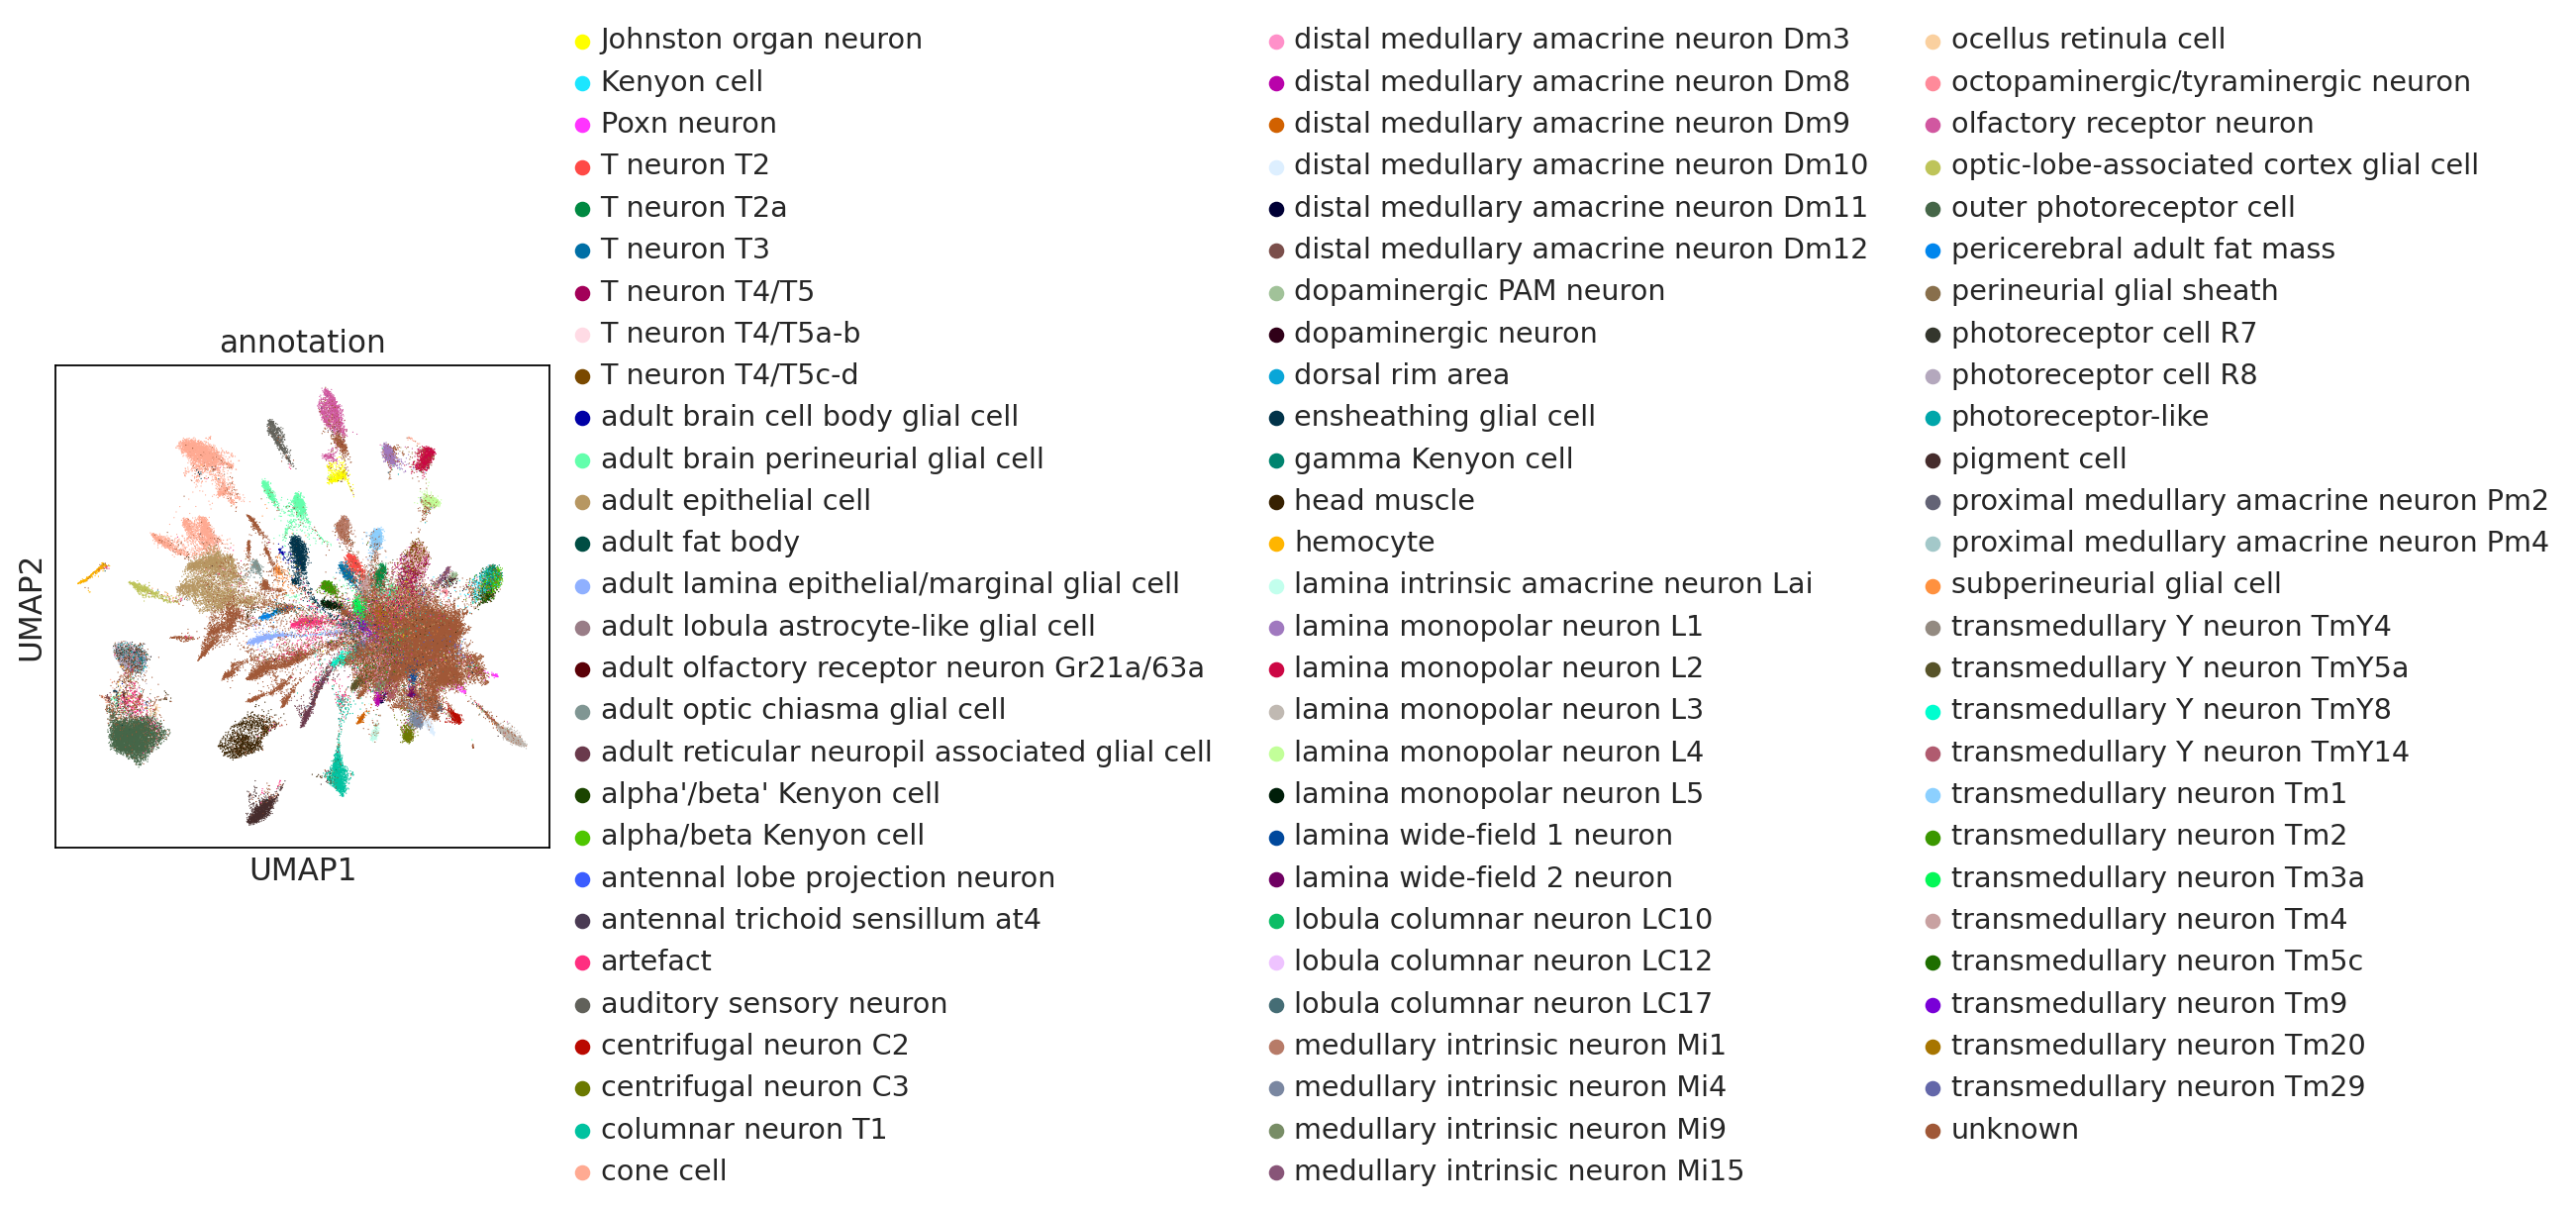

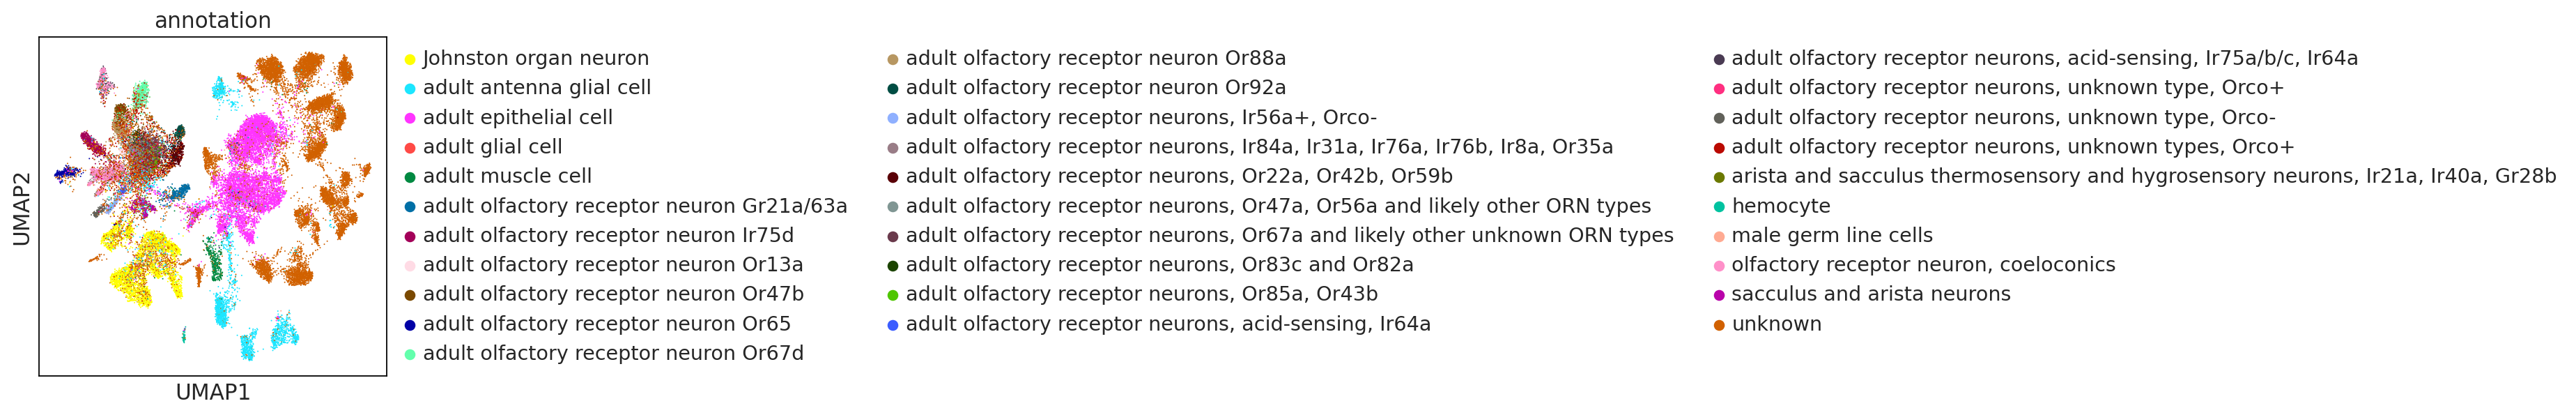

In [6]:
sc.pl.umap(fca_reference_head,color="annotation")
sc.pl.umap(fca_reference_antenna,color="annotation")

In [7]:
reference = sc.concat([fca_reference_head,fca_reference_antenna], join='outer')
reference

AnnData object with n_obs × n_vars = 137781 × 14033
    obs: 'age', 'batch', 'batch_id', 'celda_decontx__clusters', 'celda_decontx__contamination', 'celda_decontx__doublemad_predicted_outliers', 'dissection_lab', 'fca_id', 'fly_genetics', 'id', 'log_n_counts', 'log_n_genes', 'n_counts', 'n_genes', 'note', 'percent_mito', 'sample_id', 'scrublet__doublet_scores', 'scrublet__predicted_doublets', 'scrublet__predicted_doublets_based_on_10x_chromium_spec', 'sex', 'tissue', 'leiden_res0.4', 'leiden_res0.6', 'leiden_res0.8', 'leiden_res1.0', 'leiden_res1.2', 'leiden_res1.4', 'leiden_res1.6', 'leiden_res1.8', 'leiden_res10.0', 'leiden_res12.0', 'leiden_res14.0', 'leiden_res16.0', 'leiden_res18.0', 'leiden_res2.0', 'leiden_res20.0', 'leiden_res25.0', 'leiden_res4.0', 'leiden_res50.0', 'leiden_res6.0', 'leiden_res8.0', 'annotation', 'broad_annotation', 'broad_annotation_extrapolated', 'tissue_batch'
    obsm: 'X_pca', 'X_tsne', 'X_umap'

In [8]:
## read query datasets
w1118_42d = sc.read_h5ad(inputpath.joinpath('w1118_42d_sc.h5'))
w1118_42d.raw = w1118_42d

w1118_42d.obs['batch'] = "0"
w1118_42d.obs['age'] = "42"
w1118_42d.obs['sex'] = "mix"
w1118_42d.obs['fly_genetics'] = "W1118" #NOT lower case w1118 to match reference. 
w1118_42d.obs['dissection_lab'] = "mccall"
w1118_42d.obs['tissue'] = "w1118_head"
w1118_42d.obs['tissue_batch'] = w1118_42d.obs['batch'].astype(str)+"_"+w1118_42d.obs['tissue'].astype(str)

w1118_42d.obs['batch'] = w1118_42d.obs['batch'].astype('category')
w1118_42d.obs['age'] = w1118_42d.obs['age'].astype('category')
w1118_42d.obs['sex'] = w1118_42d.obs['sex'].astype('category')
w1118_42d.obs['fly_genetics'] = w1118_42d.obs['fly_genetics'].astype('category')
w1118_42d.obs['dissection_lab'] = w1118_42d.obs['dissection_lab'].astype('category')
w1118_42d.obs['tissue'] = w1118_42d.obs['tissue'].astype('category')
w1118_42d.obs['tissue_batch'] = w1118_42d.obs['tissue_batch'].astype('category')

print(w1118_42d.shape)


(8200, 11652)


In [9]:
drprnull_42d = sc.read_h5ad(inputpath.joinpath('drprnull_42d_sc.h5'))
drprnull_42d.raw = drprnull_42d

drprnull_42d.obs['batch'] = "0"
drprnull_42d.obs['age'] = "42"
drprnull_42d.obs['sex'] = "mix"
drprnull_42d.obs['fly_genetics'] = "drprnull"
drprnull_42d.obs['dissection_lab'] = "mccall"
drprnull_42d.obs['tissue'] = "drprnull_head"
drprnull_42d.obs['tissue_batch'] = drprnull_42d.obs['batch'].astype(str)+"_"+drprnull_42d.obs['tissue'].astype(str)

drprnull_42d.obs['batch'] = drprnull_42d.obs['batch'].astype('category')
drprnull_42d.obs['age'] = drprnull_42d.obs['age'].astype('category')
drprnull_42d.obs['sex'] = drprnull_42d.obs['sex'].astype('category')
drprnull_42d.obs['fly_genetics'] = drprnull_42d.obs['fly_genetics'].astype('category')
drprnull_42d.obs['dissection_lab'] = drprnull_42d.obs['dissection_lab'].astype('category')
drprnull_42d.obs['tissue'] = drprnull_42d.obs['tissue'].astype('category')
drprnull_42d.obs['tissue_batch'] = drprnull_42d.obs['tissue_batch'].astype('category')

print(drprnull_42d.shape)

(6121, 11903)


In [10]:
print(w1118_42d.X.min(),w1118_42d.X.max())
print(drprnull_42d.X.min(),drprnull_42d.X.max())
print(fca_reference_head.X.min(),fca_reference_head.X.max())
print(fca_reference_antenna.X.min(),fca_reference_antenna.X.max())

0.0 714.0
0.0 1089.0
0.0 1444.0
0.0 1185.0


In [11]:
query = sc.concat([w1118_42d,drprnull_42d], join='outer')
query

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


AnnData object with n_obs × n_vars = 14321 × 12349
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'log1p_total_counts_mt', 'outlier', 'mt_outlier', 'batch', 'age', 'sex', 'fly_genetics', 'dissection_lab', 'tissue', 'tissue_batch'

## Train model on head reference 

In [12]:
combined = sc.concat([fca_reference_antenna, fca_reference_head, w1118_42d,drprnull_42d], join='outer')
combined

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


AnnData object with n_obs × n_vars = 152102 × 14270
    obs: 'age', 'batch', 'batch_id', 'celda_decontx__clusters', 'celda_decontx__contamination', 'celda_decontx__doublemad_predicted_outliers', 'dissection_lab', 'fca_id', 'fly_genetics', 'id', 'log_n_counts', 'log_n_genes', 'n_counts', 'n_genes', 'note', 'percent_mito', 'sample_id', 'scrublet__doublet_scores', 'scrublet__predicted_doublets', 'scrublet__predicted_doublets_based_on_10x_chromium_spec', 'sex', 'tissue', 'leiden_res0.4', 'leiden_res0.6', 'leiden_res0.8', 'leiden_res1.0', 'leiden_res1.2', 'leiden_res1.4', 'leiden_res1.6', 'leiden_res1.8', 'leiden_res10.0', 'leiden_res2.0', 'leiden_res4.0', 'leiden_res6.0', 'leiden_res8.0', 'annotation', 'broad_annotation', 'broad_annotation_extrapolated', 'tissue_batch', 'leiden_res12.0', 'leiden_res14.0', 'leiden_res16.0', 'leiden_res18.0', 'leiden_res20.0', 'leiden_res25.0', 'leiden_res50.0', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'log1p_n_genes_by_counts

In [13]:
combined.obs

age batch  batch_id  \
AAACCCAAGTTGGGAC-6e294c34__FCA55_Male_antenna_a...   5     0       4.0   
AAACCCACACGTCGGT-6e294c34__FCA55_Male_antenna_a...   5     0       4.0   
AAACCCAGTAGTAAGT-6e294c34__FCA55_Male_antenna_a...   5     0       4.0   
AAACCCAGTGACTATC-6e294c34__FCA55_Male_antenna_a...   5     0       4.0   
AAACCCAGTGCGACAA-6e294c34__FCA55_Male_antenna_a...   5     0       4.0   
...                                                 ..   ...       ...   
TTTGTTGGTAACTTCG-1                                  42     0       NaN   
TTTGTTGGTCATCAGT-1                                  42     0       NaN   
TTTGTTGGTGAGCTCC-1                                  42     0       NaN   
TTTGTTGGTTCCGTTC-1                                  42     0       NaN   
TTTGTTGTCGAGTTGT-1                                  42     0       NaN   

                                                    celda_decontx__clusters  \
AAACCCAAGTTGGGAC-6e294c34__FCA55_Male_antenna_a...                      1.0   
AAACCCACACGTCGGT-6e294c34__FCA55_Male_antenna_a...                      1.0   
AAACCCAGTAGTAAGT-6e294c34__FCA55_Male_antenna_a...                      2.0   
AAACCCAGTGACTATC-6e294c34__FCA55_Male_antenna_a...                      2.0   
AAACCCAGTGCGACAA-6e294c34__FCA55_Male_antenna_a...                      3.0   
...                                                                     ...   
TTTGTTGGTAACTTCG-1                                                      NaN   
TTTGTTGGTCATCAGT-1                                                      NaN   
TTTGTTGGTGAGCTCC-1                                                      NaN   
TTTGTTGGTTCCGTTC-1                                                      NaN   
TTTGTTGTCGAGTTGT-1                                                      NaN   

                                                    celda_decontx__contamination  \
AAACCCAAGTTGGGAC-6e294c34__FCA55_Male_antenna_a...                      0.159537   
AAACCCACACGTCGGT-6e294c34__FCA55_Male_antenna_a...                      0.021540   
AAACCCAGTAGTAAGT-6e294c34__FCA55_Male_antenna_a...                      0.269333   
AAACCCAGTGACTATC-6e294c34__FCA55_Male_antenna_a...                      0.557898   
AAACCCAGTGCGACAA-6e294c34__FCA55_Male_antenna_a...                      0.166683   
...                                                                          ...   
TTTGTTGGTAACTTCG-1                                                           NaN   
TTTGTTGGTCATCAGT-1                                                           NaN   
TTTGTTGGTGAGCTCC-1                                                           NaN   
TTTGTTGGTTCCGTTC-1                                                           NaN   
TTTGTTGTCGAGTTGT-1                                                           NaN   

                                                    celda_decontx__doublemad_predicted_outliers  \
AAACCCAAGTTGGGAC-6e294c34__FCA55_Male_antenna_a...                                        False   
AAACCCACACGTCGGT-6e294c34__FCA55_Male_antenna_a...                                        False   
AAACCCAGTAGTAAGT-6e294c34__FCA55_Male_antenna_a...                                        False   
AAACCCAGTGACTATC-6e294c34__FCA55_Male_antenna_a...                                        False   
AAACCCAGTGCGACAA-6e294c34__FCA55_Male_antenna_a...                                        False   
...                                                                                         ...   
TTTGTTGGTAACTTCG-1                                                                         <NA>   
TTTGTTGGTCATCAGT-1                                                                         <NA>   
TTTGTTGGTGAGCTCC-1                                                                         <NA>   
TTTGTTGGTTCCGTTC-1                                                                         <NA>   
TTTGTTGTCGAGTTGT-1                                                                         <NA>   

               

In [14]:
print(combined.X.max(),combined.X.min())

1444.0 0.0


In [15]:
combined.layers['counts'] = combined.X.copy()
sc.pp.normalize_total(combined, target_sum=1e4)
sc.pp.log1p(combined)
combined.raw = combined


normalizing counts per cell
    finished (0:00:00)


In [16]:
print(combined.layers['counts'].max(),combined.layers['counts'].min())
print(combined.X.max(),combined.X.min())

1444.0 0.0
8.615613 0.0


In [17]:
sc.pp.highly_variable_genes(
    combined,
    n_top_genes=2000,
    batch_key="tissue_batch",
    subset=True)
combined

extracting highly variable genes
    finished (0:00:02)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


AnnData object with n_obs × n_vars = 152102 × 2000
    obs: 'age', 'batch', 'batch_id', 'celda_decontx__clusters', 'celda_decontx__contamination', 'celda_decontx__doublemad_predicted_outliers', 'dissection_lab', 'fca_id', 'fly_genetics', 'id', 'log_n_counts', 'log_n_genes', 'n_counts', 'n_genes', 'note', 'percent_mito', 'sample_id', 'scrublet__doublet_scores', 'scrublet__predicted_doublets', 'scrublet__predicted_doublets_based_on_10x_chromium_spec', 'sex', 'tissue', 'leiden_res0.4', 'leiden_res0.6', 'leiden_res0.8', 'leiden_res1.0', 'leiden_res1.2', 'leiden_res1.4', 'leiden_res1.6', 'leiden_res1.8', 'leiden_res10.0', 'leiden_res2.0', 'leiden_res4.0', 'leiden_res6.0', 'leiden_res8.0', 'annotation', 'broad_annotation', 'broad_annotation_extrapolated', 'tissue_batch', 'leiden_res12.0', 'leiden_res14.0', 'leiden_res16.0', 'leiden_res18.0', 'leiden_res20.0', 'leiden_res25.0', 'leiden_res50.0', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'log1p_n_genes_by_counts'

In [18]:
sca.models.SCVI.setup_anndata(combined, 
                              batch_key="tissue_batch",
                              categorical_covariate_keys=["age","fly_genetics","tissue","dissection_lab","sex"])

vae = sca.models.SCVI(
    combined,
    n_layers=2,
    n_latent=30,
    encode_covariates=True,
    deeply_inject_covariates=True,
    use_layer_norm="both",
    use_batch_norm="none"
)
vae.train(max_epochs=200, check_val_every_n_epoch = 1)
print(vae)

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A40') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [6]


Epoch 1/200:   0%|          | 0/200 [00:00<?, ?it/s]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 2/200:   0%|          | 1/200 [00:08<29:34,  8.92s/it, v_num=1, train_loss_step=300, train_loss_epoch=318]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 3/200:   1%|          | 2/200 [00:17<28:55,  8.77s/it, v_num=1, train_loss_step=296, train_loss_epoch=296]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 4/200:   2%|▏         | 3/200 [00:26<28:35,  8.71s/it, v_num=1, train_loss_step=280, train_loss_epoch=289]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 5/200:   2%|▏         | 4/200 [00:34<28:20,  8.68s/it, v_num=1, train_loss_step=270, train_loss_epoch=284]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 6/200:   2%|▎         | 5/200 [00:43<28:07,  8.65s/it, v_num=1, train_loss_step=278, train_loss_epoch=281]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 7/200:   3%|▎         | 6/200 [00:52<27:57,  8.65s/it, v_num=1, train_loss_step=283, train_loss_epoch=279]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 8/200:   4%|▎         | 7/200 [01:00<27:47,  8.64s/it, v_num=1, train_loss_step=264, train_loss_epoch=277]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 9/200:   4%|▍         | 8/200 [01:09<27:37,  8.63s/it, v_num=1, train_loss_step=268, train_loss_epoch=276]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 10/200:   4%|▍         | 9/200 [01:17<27:28,  8.63s/it, v_num=1, train_loss_step=270, train_loss_epoch=274]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 11/200:   5%|▌         | 10/200 [01:26<27:21,  8.64s/it, v_num=1, train_loss_step=263, train_loss_epoch=273]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 12/200:   6%|▌         | 11/200 [01:35<27:13,  8.64s/it, v_num=1, train_loss_step=269, train_loss_epoch=273]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 13/200:   6%|▌         | 12/200 [01:43<27:07,  8.66s/it, v_num=1, train_loss_step=280, train_loss_epoch=272]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 14/200:   6%|▋         | 13/200 [01:52<26:59,  8.66s/it, v_num=1, train_loss_step=257, train_loss_epoch=272]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 15/200:   7%|▋         | 14/200 [02:01<26:49,  8.65s/it, v_num=1, train_loss_step=276, train_loss_epoch=271]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 16/200:   8%|▊         | 15/200 [02:09<26:39,  8.64s/it, v_num=1, train_loss_step=266, train_loss_epoch=271]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 17/200:   8%|▊         | 16/200 [02:18<26:31,  8.65s/it, v_num=1, train_loss_step=269, train_loss_epoch=270]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 18/200:   8%|▊         | 17/200 [02:27<26:25,  8.66s/it, v_num=1, train_loss_step=268, train_loss_epoch=270]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 19/200:   9%|▉         | 18/200 [02:36<26:22,  8.70s/it, v_num=1, train_loss_step=249, train_loss_epoch=270]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 20/200:  10%|▉         | 19/200 [02:44<26:11,  8.68s/it, v_num=1, train_loss_step=261, train_loss_epoch=270]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 21/200:  10%|█         | 20/200 [02:53<26:03,  8.69s/it, v_num=1, train_loss_step=257, train_loss_epoch=270]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 22/200:  10%|█         | 21/200 [03:02<25:56,  8.69s/it, v_num=1, train_loss_step=264, train_loss_epoch=269]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 23/200:  11%|█         | 22/200 [03:10<25:44,  8.68s/it, v_num=1, train_loss_step=255, train_loss_epoch=269]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 24/200:  12%|█▏        | 23/200 [03:19<25:34,  8.67s/it, v_num=1, train_loss_step=263, train_loss_epoch=269]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 25/200:  12%|█▏        | 24/200 [03:28<25:26,  8.67s/it, v_num=1, train_loss_step=268, train_loss_epoch=269]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 26/200:  12%|█▎        | 25/200 [03:36<25:16,  8.67s/it, v_num=1, train_loss_step=277, train_loss_epoch=269]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 27/200:  13%|█▎        | 26/200 [03:45<25:08,  8.67s/it, v_num=1, train_loss_step=278, train_loss_epoch=269]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 28/200:  14%|█▎        | 27/200 [03:54<24:58,  8.66s/it, v_num=1, train_loss_step=245, train_loss_epoch=269]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 29/200:  14%|█▍        | 28/200 [04:02<24:53,  8.68s/it, v_num=1, train_loss_step=265, train_loss_epoch=269]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 30/200:  14%|█▍        | 29/200 [04:11<24:47,  8.70s/it, v_num=1, train_loss_step=288, train_loss_epoch=269]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 31/200:  15%|█▌        | 30/200 [04:20<24:38,  8.70s/it, v_num=1, train_loss_step=260, train_loss_epoch=269]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 32/200:  16%|█▌        | 31/200 [04:28<24:26,  8.68s/it, v_num=1, train_loss_step=263, train_loss_epoch=269]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 33/200:  16%|█▌        | 32/200 [04:37<24:17,  8.67s/it, v_num=1, train_loss_step=273, train_loss_epoch=269]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 34/200:  16%|█▋        | 33/200 [04:46<24:12,  8.70s/it, v_num=1, train_loss_step=288, train_loss_epoch=269]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 35/200:  17%|█▋        | 34/200 [04:54<24:01,  8.68s/it, v_num=1, train_loss_step=262, train_loss_epoch=269]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 36/200:  18%|█▊        | 35/200 [05:03<23:50,  8.67s/it, v_num=1, train_loss_step=262, train_loss_epoch=269]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 37/200:  18%|█▊        | 36/200 [05:12<23:42,  8.68s/it, v_num=1, train_loss_step=252, train_loss_epoch=269]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 38/200:  18%|█▊        | 37/200 [05:20<23:36,  8.69s/it, v_num=1, train_loss_step=267, train_loss_epoch=269]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 39/200:  19%|█▉        | 38/200 [05:29<23:27,  8.69s/it, v_num=1, train_loss_step=276, train_loss_epoch=269]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 40/200:  20%|█▉        | 39/200 [05:38<23:19,  8.69s/it, v_num=1, train_loss_step=264, train_loss_epoch=269]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 41/200:  20%|██        | 40/200 [05:46<23:08,  8.68s/it, v_num=1, train_loss_step=275, train_loss_epoch=269]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 42/200:  20%|██        | 41/200 [05:55<22:58,  8.67s/it, v_num=1, train_loss_step=267, train_loss_epoch=269]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 43/200:  21%|██        | 42/200 [06:04<22:50,  8.67s/it, v_num=1, train_loss_step=285, train_loss_epoch=269]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 44/200:  22%|██▏       | 43/200 [06:13<22:44,  8.69s/it, v_num=1, train_loss_step=252, train_loss_epoch=269]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 45/200:  22%|██▏       | 44/200 [06:21<22:38,  8.71s/it, v_num=1, train_loss_step=285, train_loss_epoch=269]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 46/200:  22%|██▎       | 45/200 [06:30<22:31,  8.72s/it, v_num=1, train_loss_step=258, train_loss_epoch=269]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 47/200:  23%|██▎       | 46/200 [06:39<22:20,  8.71s/it, v_num=1, train_loss_step=242, train_loss_epoch=269]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 48/200:  24%|██▎       | 47/200 [06:47<22:09,  8.69s/it, v_num=1, train_loss_step=301, train_loss_epoch=269]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 49/200:  24%|██▍       | 48/200 [06:56<21:58,  8.68s/it, v_num=1, train_loss_step=245, train_loss_epoch=269]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 50/200:  24%|██▍       | 49/200 [07:05<21:48,  8.66s/it, v_num=1, train_loss_step=255, train_loss_epoch=269]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 51/200:  25%|██▌       | 50/200 [07:13<21:38,  8.66s/it, v_num=1, train_loss_step=279, train_loss_epoch=269]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 52/200:  26%|██▌       | 51/200 [07:22<21:29,  8.65s/it, v_num=1, train_loss_step=269, train_loss_epoch=269]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 53/200:  26%|██▌       | 52/200 [07:31<21:23,  8.68s/it, v_num=1, train_loss_step=265, train_loss_epoch=269]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 54/200:  26%|██▋       | 53/200 [07:39<21:16,  8.68s/it, v_num=1, train_loss_step=267, train_loss_epoch=269]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 55/200:  27%|██▋       | 54/200 [07:48<21:08,  8.69s/it, v_num=1, train_loss_step=251, train_loss_epoch=270]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 56/200:  28%|██▊       | 55/200 [07:57<20:57,  8.67s/it, v_num=1, train_loss_step=267, train_loss_epoch=270]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 57/200:  28%|██▊       | 56/200 [08:05<20:46,  8.66s/it, v_num=1, train_loss_step=269, train_loss_epoch=270]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 58/200:  28%|██▊       | 57/200 [08:14<20:37,  8.65s/it, v_num=1, train_loss_step=276, train_loss_epoch=270]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 59/200:  29%|██▉       | 58/200 [08:23<20:27,  8.64s/it, v_num=1, train_loss_step=284, train_loss_epoch=270]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 60/200:  30%|██▉       | 59/200 [08:31<20:18,  8.64s/it, v_num=1, train_loss_step=266, train_loss_epoch=270]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 61/200:  30%|███       | 60/200 [08:40<20:10,  8.65s/it, v_num=1, train_loss_step=279, train_loss_epoch=270]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 62/200:  30%|███       | 61/200 [08:49<20:04,  8.66s/it, v_num=1, train_loss_step=273, train_loss_epoch=270]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 63/200:  31%|███       | 62/200 [08:57<19:55,  8.66s/it, v_num=1, train_loss_step=259, train_loss_epoch=270]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 64/200:  32%|███▏      | 63/200 [09:06<19:50,  8.69s/it, v_num=1, train_loss_step=264, train_loss_epoch=270]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 65/200:  32%|███▏      | 64/200 [09:15<19:43,  8.70s/it, v_num=1, train_loss_step=255, train_loss_epoch=270]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 66/200:  32%|███▎      | 65/200 [09:23<19:31,  8.68s/it, v_num=1, train_loss_step=264, train_loss_epoch=270]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 67/200:  33%|███▎      | 66/200 [09:32<19:24,  8.69s/it, v_num=1, train_loss_step=272, train_loss_epoch=270]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 68/200:  34%|███▎      | 67/200 [09:41<19:18,  8.71s/it, v_num=1, train_loss_step=270, train_loss_epoch=270]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 69/200:  34%|███▍      | 68/200 [09:50<19:10,  8.72s/it, v_num=1, train_loss_step=280, train_loss_epoch=270]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 70/200:  34%|███▍      | 69/200 [09:58<18:59,  8.70s/it, v_num=1, train_loss_step=259, train_loss_epoch=270]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 71/200:  35%|███▌      | 70/200 [10:07<18:50,  8.69s/it, v_num=1, train_loss_step=268, train_loss_epoch=270]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 72/200:  36%|███▌      | 71/200 [10:16<18:39,  8.68s/it, v_num=1, train_loss_step=245, train_loss_epoch=270]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 73/200:  36%|███▌      | 72/200 [10:24<18:31,  8.68s/it, v_num=1, train_loss_step=273, train_loss_epoch=270]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 74/200:  36%|███▋      | 73/200 [10:33<18:23,  8.69s/it, v_num=1, train_loss_step=275, train_loss_epoch=270]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 75/200:  37%|███▋      | 74/200 [10:42<18:12,  8.67s/it, v_num=1, train_loss_step=286, train_loss_epoch=270]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 76/200:  38%|███▊      | 75/200 [10:50<18:01,  8.66s/it, v_num=1, train_loss_step=268, train_loss_epoch=270]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 77/200:  38%|███▊      | 76/200 [10:59<17:52,  8.65s/it, v_num=1, train_loss_step=276, train_loss_epoch=271]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 78/200:  38%|███▊      | 77/200 [11:07<17:43,  8.64s/it, v_num=1, train_loss_step=296, train_loss_epoch=271]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 79/200:  39%|███▉      | 78/200 [11:16<17:34,  8.64s/it, v_num=1, train_loss_step=270, train_loss_epoch=271]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 80/200:  40%|███▉      | 79/200 [11:25<17:25,  8.64s/it, v_num=1, train_loss_step=272, train_loss_epoch=271]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 81/200:  40%|████      | 80/200 [11:33<17:16,  8.64s/it, v_num=1, train_loss_step=263, train_loss_epoch=271]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 82/200:  40%|████      | 81/200 [11:42<17:07,  8.64s/it, v_num=1, train_loss_step=282, train_loss_epoch=271]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 83/200:  41%|████      | 82/200 [11:51<17:00,  8.65s/it, v_num=1, train_loss_step=252, train_loss_epoch=271]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 84/200:  42%|████▏     | 83/200 [11:59<16:54,  8.67s/it, v_num=1, train_loss_step=264, train_loss_epoch=271]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 85/200:  42%|████▏     | 84/200 [12:08<16:48,  8.69s/it, v_num=1, train_loss_step=270, train_loss_epoch=271]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 86/200:  42%|████▎     | 85/200 [12:17<16:37,  8.67s/it, v_num=1, train_loss_step=259, train_loss_epoch=271]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 87/200:  43%|████▎     | 86/200 [12:25<16:28,  8.67s/it, v_num=1, train_loss_step=272, train_loss_epoch=271]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 88/200:  44%|████▎     | 87/200 [12:34<16:18,  8.66s/it, v_num=1, train_loss_step=294, train_loss_epoch=271]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 89/200:  44%|████▍     | 88/200 [12:43<16:08,  8.65s/it, v_num=1, train_loss_step=264, train_loss_epoch=271]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 90/200:  44%|████▍     | 89/200 [12:51<16:00,  8.65s/it, v_num=1, train_loss_step=280, train_loss_epoch=271]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 91/200:  45%|████▌     | 90/200 [13:00<15:50,  8.64s/it, v_num=1, train_loss_step=269, train_loss_epoch=271]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 92/200:  46%|████▌     | 91/200 [13:09<15:43,  8.66s/it, v_num=1, train_loss_step=263, train_loss_epoch=271]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 93/200:  46%|████▌     | 92/200 [13:17<15:36,  8.67s/it, v_num=1, train_loss_step=262, train_loss_epoch=271]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 94/200:  46%|████▋     | 93/200 [13:26<15:26,  8.66s/it, v_num=1, train_loss_step=265, train_loss_epoch=271]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 95/200:  47%|████▋     | 94/200 [13:35<15:18,  8.66s/it, v_num=1, train_loss_step=260, train_loss_epoch=271]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 96/200:  48%|████▊     | 95/200 [13:43<15:10,  8.67s/it, v_num=1, train_loss_step=269, train_loss_epoch=271]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 97/200:  48%|████▊     | 96/200 [13:52<15:03,  8.69s/it, v_num=1, train_loss_step=276, train_loss_epoch=271]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 98/200:  48%|████▊     | 97/200 [14:01<14:56,  8.70s/it, v_num=1, train_loss_step=299, train_loss_epoch=272]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 99/200:  49%|████▉     | 98/200 [14:10<14:49,  8.72s/it, v_num=1, train_loss_step=260, train_loss_epoch=272]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 100/200:  50%|████▉     | 99/200 [14:18<14:40,  8.72s/it, v_num=1, train_loss_step=271, train_loss_epoch=272]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 101/200:  50%|█████     | 100/200 [14:27<14:28,  8.69s/it, v_num=1, train_loss_step=260, train_loss_epoch=272]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 102/200:  50%|█████     | 101/200 [14:36<14:20,  8.69s/it, v_num=1, train_loss_step=282, train_loss_epoch=272]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 103/200:  51%|█████     | 102/200 [14:44<14:10,  8.68s/it, v_num=1, train_loss_step=261, train_loss_epoch=272]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 104/200:  52%|█████▏    | 103/200 [14:53<14:01,  8.68s/it, v_num=1, train_loss_step=259, train_loss_epoch=272]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 105/200:  52%|█████▏    | 104/200 [15:02<13:51,  8.66s/it, v_num=1, train_loss_step=282, train_loss_epoch=272]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 106/200:  52%|█████▎    | 105/200 [15:10<13:42,  8.66s/it, v_num=1, train_loss_step=281, train_loss_epoch=272]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 107/200:  53%|█████▎    | 106/200 [15:19<13:35,  8.67s/it, v_num=1, train_loss_step=249, train_loss_epoch=272]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 108/200:  54%|█████▎    | 107/200 [15:28<13:28,  8.69s/it, v_num=1, train_loss_step=285, train_loss_epoch=272]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 109/200:  54%|█████▍    | 108/200 [15:36<13:19,  8.69s/it, v_num=1, train_loss_step=261, train_loss_epoch=272]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 110/200:  55%|█████▍    | 109/200 [15:45<13:11,  8.69s/it, v_num=1, train_loss_step=273, train_loss_epoch=272]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 111/200:  55%|█████▌    | 110/200 [15:54<13:04,  8.71s/it, v_num=1, train_loss_step=268, train_loss_epoch=272]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 112/200:  56%|█████▌    | 111/200 [16:02<12:56,  8.73s/it, v_num=1, train_loss_step=287, train_loss_epoch=272]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 113/200:  56%|█████▌    | 112/200 [16:11<12:46,  8.71s/it, v_num=1, train_loss_step=255, train_loss_epoch=272]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 114/200:  56%|█████▋    | 113/200 [16:20<12:38,  8.72s/it, v_num=1, train_loss_step=241, train_loss_epoch=272]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 115/200:  57%|█████▋    | 114/200 [16:29<12:29,  8.72s/it, v_num=1, train_loss_step=299, train_loss_epoch=272]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 116/200:  57%|█████▊    | 115/200 [16:37<12:18,  8.69s/it, v_num=1, train_loss_step=257, train_loss_epoch=272]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 117/200:  58%|█████▊    | 116/200 [16:46<12:08,  8.68s/it, v_num=1, train_loss_step=287, train_loss_epoch=273]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 118/200:  58%|█████▊    | 117/200 [16:55<11:59,  8.67s/it, v_num=1, train_loss_step=262, train_loss_epoch=273]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 119/200:  59%|█████▉    | 118/200 [17:03<11:50,  8.67s/it, v_num=1, train_loss_step=267, train_loss_epoch=273]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 120/200:  60%|█████▉    | 119/200 [17:12<11:41,  8.66s/it, v_num=1, train_loss_step=281, train_loss_epoch=273]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 121/200:  60%|██████    | 120/200 [17:21<11:32,  8.66s/it, v_num=1, train_loss_step=279, train_loss_epoch=273]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 122/200:  60%|██████    | 121/200 [17:29<11:23,  8.65s/it, v_num=1, train_loss_step=274, train_loss_epoch=273]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 123/200:  61%|██████    | 122/200 [17:38<11:14,  8.65s/it, v_num=1, train_loss_step=287, train_loss_epoch=273]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 124/200:  62%|██████▏   | 123/200 [17:46<11:06,  8.66s/it, v_num=1, train_loss_step=296, train_loss_epoch=273]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 125/200:  62%|██████▏   | 124/200 [17:55<10:59,  8.68s/it, v_num=1, train_loss_step=258, train_loss_epoch=273]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 126/200:  62%|██████▎   | 125/200 [18:04<10:51,  8.69s/it, v_num=1, train_loss_step=268, train_loss_epoch=273]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 127/200:  63%|██████▎   | 126/200 [18:13<10:43,  8.69s/it, v_num=1, train_loss_step=260, train_loss_epoch=273]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 128/200:  64%|██████▎   | 127/200 [18:21<10:35,  8.71s/it, v_num=1, train_loss_step=273, train_loss_epoch=273]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 129/200:  64%|██████▍   | 128/200 [18:30<10:27,  8.71s/it, v_num=1, train_loss_step=296, train_loss_epoch=273]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 130/200:  64%|██████▍   | 129/200 [18:39<10:19,  8.73s/it, v_num=1, train_loss_step=271, train_loss_epoch=273]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 131/200:  65%|██████▌   | 130/200 [18:48<10:12,  8.75s/it, v_num=1, train_loss_step=295, train_loss_epoch=273]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 132/200:  66%|██████▌   | 131/200 [18:56<10:02,  8.73s/it, v_num=1, train_loss_step=284, train_loss_epoch=273]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 133/200:  66%|██████▌   | 132/200 [19:05<09:52,  8.71s/it, v_num=1, train_loss_step=256, train_loss_epoch=273]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 134/200:  66%|██████▋   | 133/200 [19:14<09:42,  8.70s/it, v_num=1, train_loss_step=260, train_loss_epoch=274]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 135/200:  67%|██████▋   | 134/200 [19:22<09:33,  8.68s/it, v_num=1, train_loss_step=286, train_loss_epoch=274]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 136/200:  68%|██████▊   | 135/200 [19:31<09:23,  8.67s/it, v_num=1, train_loss_step=260, train_loss_epoch=274]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 137/200:  68%|██████▊   | 136/200 [19:40<09:14,  8.67s/it, v_num=1, train_loss_step=288, train_loss_epoch=274]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 138/200:  68%|██████▊   | 137/200 [19:48<09:06,  8.68s/it, v_num=1, train_loss_step=283, train_loss_epoch=274]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 139/200:  69%|██████▉   | 138/200 [19:57<08:59,  8.70s/it, v_num=1, train_loss_step=270, train_loss_epoch=274]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 140/200:  70%|██████▉   | 139/200 [20:06<08:51,  8.71s/it, v_num=1, train_loss_step=262, train_loss_epoch=274]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 141/200:  70%|███████   | 140/200 [20:15<08:42,  8.71s/it, v_num=1, train_loss_step=272, train_loss_epoch=274]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 142/200:  70%|███████   | 141/200 [20:23<08:33,  8.71s/it, v_num=1, train_loss_step=280, train_loss_epoch=274]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 143/200:  71%|███████   | 142/200 [20:32<08:24,  8.69s/it, v_num=1, train_loss_step=271, train_loss_epoch=274]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 144/200:  72%|███████▏  | 143/200 [20:41<08:16,  8.71s/it, v_num=1, train_loss_step=263, train_loss_epoch=274]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 145/200:  72%|███████▏  | 144/200 [20:49<08:08,  8.72s/it, v_num=1, train_loss_step=293, train_loss_epoch=274]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 146/200:  72%|███████▎  | 145/200 [20:58<08:00,  8.73s/it, v_num=1, train_loss_step=307, train_loss_epoch=274]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 147/200:  73%|███████▎  | 146/200 [21:07<07:50,  8.71s/it, v_num=1, train_loss_step=259, train_loss_epoch=274]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 148/200:  74%|███████▎  | 147/200 [21:15<07:41,  8.70s/it, v_num=1, train_loss_step=286, train_loss_epoch=274]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 149/200:  74%|███████▍  | 148/200 [21:24<07:32,  8.71s/it, v_num=1, train_loss_step=269, train_loss_epoch=274]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 150/200:  74%|███████▍  | 149/200 [21:33<07:24,  8.71s/it, v_num=1, train_loss_step=284, train_loss_epoch=274]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 151/200:  75%|███████▌  | 150/200 [21:42<07:15,  8.72s/it, v_num=1, train_loss_step=294, train_loss_epoch=275]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 152/200:  76%|███████▌  | 151/200 [21:50<07:06,  8.70s/it, v_num=1, train_loss_step=253, train_loss_epoch=275]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 153/200:  76%|███████▌  | 152/200 [21:59<06:58,  8.72s/it, v_num=1, train_loss_step=286, train_loss_epoch=275]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 154/200:  76%|███████▋  | 153/200 [22:08<06:50,  8.73s/it, v_num=1, train_loss_step=285, train_loss_epoch=275]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 155/200:  77%|███████▋  | 154/200 [22:17<06:41,  8.73s/it, v_num=1, train_loss_step=268, train_loss_epoch=275]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 156/200:  78%|███████▊  | 155/200 [22:25<06:33,  8.74s/it, v_num=1, train_loss_step=262, train_loss_epoch=275]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 157/200:  78%|███████▊  | 156/200 [22:34<06:23,  8.71s/it, v_num=1, train_loss_step=274, train_loss_epoch=275]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 158/200:  78%|███████▊  | 157/200 [22:43<06:13,  8.68s/it, v_num=1, train_loss_step=269, train_loss_epoch=275]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 159/200:  79%|███████▉  | 158/200 [22:51<06:04,  8.67s/it, v_num=1, train_loss_step=275, train_loss_epoch=275]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 160/200:  80%|███████▉  | 159/200 [23:00<05:54,  8.66s/it, v_num=1, train_loss_step=271, train_loss_epoch=275]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 161/200:  80%|████████  | 160/200 [23:09<05:46,  8.66s/it, v_num=1, train_loss_step=293, train_loss_epoch=275]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 162/200:  80%|████████  | 161/200 [23:17<05:38,  8.67s/it, v_num=1, train_loss_step=260, train_loss_epoch=275]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 163/200:  81%|████████  | 162/200 [23:26<05:29,  8.68s/it, v_num=1, train_loss_step=263, train_loss_epoch=275]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 164/200:  82%|████████▏ | 163/200 [23:35<05:21,  8.68s/it, v_num=1, train_loss_step=284, train_loss_epoch=275]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 165/200:  82%|████████▏ | 164/200 [23:43<05:12,  8.69s/it, v_num=1, train_loss_step=243, train_loss_epoch=275]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 166/200:  82%|████████▎ | 165/200 [23:52<05:04,  8.70s/it, v_num=1, train_loss_step=261, train_loss_epoch=275]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 167/200:  83%|████████▎ | 166/200 [24:01<04:55,  8.69s/it, v_num=1, train_loss_step=279, train_loss_epoch=275]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 168/200:  84%|████████▎ | 167/200 [24:09<04:46,  8.67s/it, v_num=1, train_loss_step=278, train_loss_epoch=276]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 169/200:  84%|████████▍ | 168/200 [24:18<04:38,  8.69s/it, v_num=1, train_loss_step=283, train_loss_epoch=276]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 170/200:  84%|████████▍ | 169/200 [24:27<04:29,  8.71s/it, v_num=1, train_loss_step=271, train_loss_epoch=276]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 171/200:  85%|████████▌ | 170/200 [24:35<04:20,  8.69s/it, v_num=1, train_loss_step=272, train_loss_epoch=276]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 172/200:  86%|████████▌ | 171/200 [24:44<04:11,  8.67s/it, v_num=1, train_loss_step=276, train_loss_epoch=276]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 173/200:  86%|████████▌ | 172/200 [24:53<04:02,  8.66s/it, v_num=1, train_loss_step=261, train_loss_epoch=276]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 174/200:  86%|████████▋ | 173/200 [25:01<03:53,  8.66s/it, v_num=1, train_loss_step=269, train_loss_epoch=276]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 175/200:  87%|████████▋ | 174/200 [25:10<03:45,  8.66s/it, v_num=1, train_loss_step=278, train_loss_epoch=276]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 176/200:  88%|████████▊ | 175/200 [25:19<03:36,  8.64s/it, v_num=1, train_loss_step=288, train_loss_epoch=276]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 177/200:  88%|████████▊ | 176/200 [25:27<03:27,  8.66s/it, v_num=1, train_loss_step=284, train_loss_epoch=276]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 178/200:  88%|████████▊ | 177/200 [25:36<03:18,  8.65s/it, v_num=1, train_loss_step=291, train_loss_epoch=276]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 179/200:  89%|████████▉ | 178/200 [25:45<03:10,  8.64s/it, v_num=1, train_loss_step=286, train_loss_epoch=276]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 180/200:  90%|████████▉ | 179/200 [25:53<03:01,  8.64s/it, v_num=1, train_loss_step=284, train_loss_epoch=276]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 181/200:  90%|█████████ | 180/200 [26:02<02:52,  8.64s/it, v_num=1, train_loss_step=283, train_loss_epoch=276]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 182/200:  90%|█████████ | 181/200 [26:10<02:44,  8.64s/it, v_num=1, train_loss_step=270, train_loss_epoch=276]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 183/200:  91%|█████████ | 182/200 [26:19<02:35,  8.63s/it, v_num=1, train_loss_step=287, train_loss_epoch=276]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 184/200:  92%|█████████▏| 183/200 [26:28<02:26,  8.64s/it, v_num=1, train_loss_step=275, train_loss_epoch=276]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 185/200:  92%|█████████▏| 184/200 [26:36<02:18,  8.64s/it, v_num=1, train_loss_step=278, train_loss_epoch=276]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 186/200:  92%|█████████▎| 185/200 [26:45<02:10,  8.68s/it, v_num=1, train_loss_step=269, train_loss_epoch=277]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 187/200:  93%|█████████▎| 186/200 [26:54<02:01,  8.69s/it, v_num=1, train_loss_step=290, train_loss_epoch=277]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 188/200:  94%|█████████▎| 187/200 [27:03<01:53,  8.70s/it, v_num=1, train_loss_step=306, train_loss_epoch=277]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 189/200:  94%|█████████▍| 188/200 [27:11<01:44,  8.67s/it, v_num=1, train_loss_step=302, train_loss_epoch=277]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 190/200:  94%|█████████▍| 189/200 [27:20<01:35,  8.67s/it, v_num=1, train_loss_step=293, train_loss_epoch=277]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 191/200:  95%|█████████▌| 190/200 [27:29<01:26,  8.70s/it, v_num=1, train_loss_step=277, train_loss_epoch=277]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 192/200:  96%|█████████▌| 191/200 [27:37<01:18,  8.70s/it, v_num=1, train_loss_step=279, train_loss_epoch=277]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 193/200:  96%|█████████▌| 192/200 [27:46<01:09,  8.69s/it, v_num=1, train_loss_step=285, train_loss_epoch=277]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 194/200:  96%|█████████▋| 193/200 [27:55<01:00,  8.68s/it, v_num=1, train_loss_step=259, train_loss_epoch=277]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 195/200:  97%|█████████▋| 194/200 [28:03<00:52,  8.67s/it, v_num=1, train_loss_step=269, train_loss_epoch=277]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 196/200:  98%|█████████▊| 195/200 [28:12<00:43,  8.66s/it, v_num=1, train_loss_step=282, train_loss_epoch=277]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 197/200:  98%|█████████▊| 196/200 [28:21<00:34,  8.65s/it, v_num=1, train_loss_step=295, train_loss_epoch=277]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 198/200:  98%|█████████▊| 197/200 [28:29<00:25,  8.66s/it, v_num=1, train_loss_step=261, train_loss_epoch=277]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 199/200:  99%|█████████▉| 198/200 [28:38<00:17,  8.65s/it, v_num=1, train_loss_step=269, train_loss_epoch=277]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 200/200: 100%|█████████▉| 199/200 [28:47<00:08,  8.66s/it, v_num=1, train_loss_step=290, train_loss_epoch=277]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 200/200: 100%|██████████| 200/200 [28:55<00:00,  8.65s/it, v_num=1, train_loss_step=254, train_loss_epoch=277]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [28:55<00:00,  8.68s/it, v_num=1, train_loss_step=254, train_loss_epoch=277]


SCVI model with the following parameters: 
n_hidden: 128, n_latent: 30, n_layers: 2, dropout_rate: 0.1, dispersion: gene, gene_likelihood: zinb, 
latent_distribution: normal.
Training status: Trained
Model's adata is minified?: False

/scratch/6735487.1.iris-gpu-pub/ipykernel_116641/3152978947.py:20: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


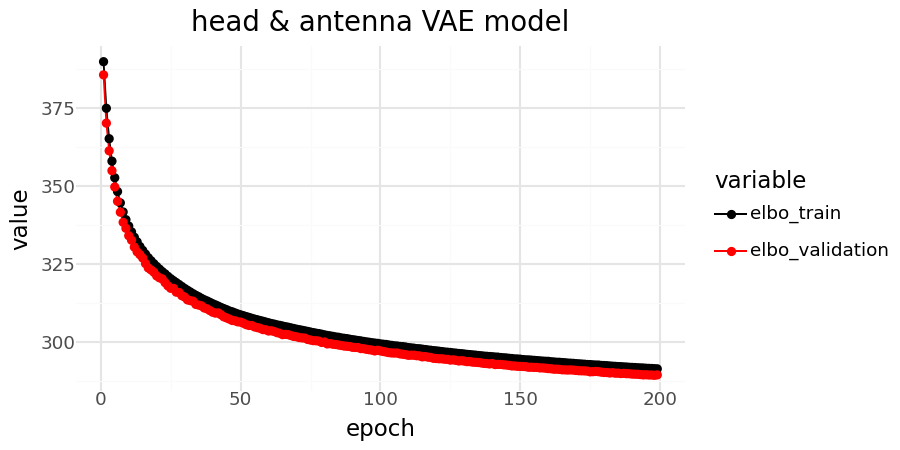

In [19]:
history_df = (
    vae.history['elbo_train'].astype(float)
    .join(vae.history['elbo_validation'].astype(float))
    .reset_index()
    .melt(id_vars = ['epoch'])
)

p.options.figure_size = 6, 3

p_ = (
    p.ggplot(p.aes(x = 'epoch', y = 'value', color = 'variable'), history_df.query('epoch > 0'))
    + p.geom_line()
    + p.geom_point()
    + p.scale_color_manual({'elbo_train': 'black', 'elbo_validation': 'red'})
    + p.ggtitle("head & antenna VAE model")
    + p.theme_minimal()
)


print(p_)

In [20]:
head_antenna_model = "/projectnb/mccall/sbandyadka/drpr42d_snrnaseq/analysis/scarches/head_antenna_model/"
vae.save(head_antenna_model, overwrite=True)

In [21]:
combined.obs['broad_annotation'] = combined.obs['broad_annotation'].cat.add_categories('Unlabeled')
combined.obs = combined.obs.fillna(value={'broad_annotation' : 'Unlabeled'})
combined.obs['annotation'] = combined.obs['annotation'].cat.add_categories('Unlabeled')
combined.obs = combined.obs.fillna(value={'annotation' : 'Unlabeled'})
combined.obs

age batch  batch_id  \
AAACCCAAGTTGGGAC-6e294c34__FCA55_Male_antenna_a...   5     0       4.0   
AAACCCACACGTCGGT-6e294c34__FCA55_Male_antenna_a...   5     0       4.0   
AAACCCAGTAGTAAGT-6e294c34__FCA55_Male_antenna_a...   5     0       4.0   
AAACCCAGTGACTATC-6e294c34__FCA55_Male_antenna_a...   5     0       4.0   
AAACCCAGTGCGACAA-6e294c34__FCA55_Male_antenna_a...   5     0       4.0   
...                                                 ..   ...       ...   
TTTGTTGGTAACTTCG-1                                  42     0       NaN   
TTTGTTGGTCATCAGT-1                                  42     0       NaN   
TTTGTTGGTGAGCTCC-1                                  42     0       NaN   
TTTGTTGGTTCCGTTC-1                                  42     0       NaN   
TTTGTTGTCGAGTTGT-1                                  42     0       NaN   

                                                    celda_decontx__clusters  \
AAACCCAAGTTGGGAC-6e294c34__FCA55_Male_antenna_a...                      1.0   
AAACCCACACGTCGGT-6e294c34__FCA55_Male_antenna_a...                      1.0   
AAACCCAGTAGTAAGT-6e294c34__FCA55_Male_antenna_a...                      2.0   
AAACCCAGTGACTATC-6e294c34__FCA55_Male_antenna_a...                      2.0   
AAACCCAGTGCGACAA-6e294c34__FCA55_Male_antenna_a...                      3.0   
...                                                                     ...   
TTTGTTGGTAACTTCG-1                                                      NaN   
TTTGTTGGTCATCAGT-1                                                      NaN   
TTTGTTGGTGAGCTCC-1                                                      NaN   
TTTGTTGGTTCCGTTC-1                                                      NaN   
TTTGTTGTCGAGTTGT-1                                                      NaN   

                                                    celda_decontx__contamination  \
AAACCCAAGTTGGGAC-6e294c34__FCA55_Male_antenna_a...                      0.159537   
AAACCCACACGTCGGT-6e294c34__FCA55_Male_antenna_a...                      0.021540   
AAACCCAGTAGTAAGT-6e294c34__FCA55_Male_antenna_a...                      0.269333   
AAACCCAGTGACTATC-6e294c34__FCA55_Male_antenna_a...                      0.557898   
AAACCCAGTGCGACAA-6e294c34__FCA55_Male_antenna_a...                      0.166683   
...                                                                          ...   
TTTGTTGGTAACTTCG-1                                                           NaN   
TTTGTTGGTCATCAGT-1                                                           NaN   
TTTGTTGGTGAGCTCC-1                                                           NaN   
TTTGTTGGTTCCGTTC-1                                                           NaN   
TTTGTTGTCGAGTTGT-1                                                           NaN   

                                                    celda_decontx__doublemad_predicted_outliers  \
AAACCCAAGTTGGGAC-6e294c34__FCA55_Male_antenna_a...                                        False   
AAACCCACACGTCGGT-6e294c34__FCA55_Male_antenna_a...                                        False   
AAACCCAGTAGTAAGT-6e294c34__FCA55_Male_antenna_a...                                        False   
AAACCCAGTGACTATC-6e294c34__FCA55_Male_antenna_a...                                        False   
AAACCCAGTGCGACAA-6e294c34__FCA55_Male_antenna_a...                                        False   
...                                                                                         ...   
TTTGTTGGTAACTTCG-1                                                                         <NA>   
TTTGTTGGTCATCAGT-1                                                                         <NA>   
TTTGTTGGTGAGCTCC-1                                                                         <NA>   
TTTGTTGGTTCCGTTC-1                                                                         <NA>   
TTTGTTGTCGAGTTGT-1                                                                         <NA>   

               

In [22]:
broad_annotation_vae = sca.models.SCANVI.from_scvi_model(vae,adata=combined, unlabeled_category="Unlabeled",labels_key="broad_annotation")
broad_annotation_vae.train(max_epochs=50, check_val_every_n_epoch = 1)


INFO     Training for 50 epochs.                                                                                   


/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [6]


Epoch 1/50:   0%|          | 0/50 [00:00<?, ?it/s]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 2/50:   2%|▏         | 1/50 [00:18<15:26, 18.92s/it, v_num=1, train_loss_step=318, train_loss_epoch=315]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 3/50:   4%|▍         | 2/50 [00:37<15:06, 18.88s/it, v_num=1, train_loss_step=303, train_loss_epoch=300]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 4/50:   6%|▌         | 3/50 [00:56<14:50, 18.94s/it, v_num=1, train_loss_step=290, train_loss_epoch=297]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 5/50:   8%|▊         | 4/50 [01:15<14:31, 18.94s/it, v_num=1, train_loss_step=306, train_loss_epoch=294]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 6/50:  10%|█         | 5/50 [01:34<14:10, 18.90s/it, v_num=1, train_loss_step=274, train_loss_epoch=292]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 7/50:  12%|█▏        | 6/50 [01:53<13:50, 18.87s/it, v_num=1, train_loss_step=274, train_loss_epoch=291]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 8/50:  14%|█▍        | 7/50 [02:12<13:29, 18.83s/it, v_num=1, train_loss_step=281, train_loss_epoch=290]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 9/50:  16%|█▌        | 8/50 [02:30<13:09, 18.80s/it, v_num=1, train_loss_step=276, train_loss_epoch=289]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 10/50:  18%|█▊        | 9/50 [02:49<12:49, 18.77s/it, v_num=1, train_loss_step=284, train_loss_epoch=288]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 11/50:  20%|██        | 10/50 [03:08<12:30, 18.76s/it, v_num=1, train_loss_step=281, train_loss_epoch=287]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 12/50:  22%|██▏       | 11/50 [03:27<12:13, 18.81s/it, v_num=1, train_loss_step=304, train_loss_epoch=287]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 13/50:  24%|██▍       | 12/50 [03:46<11:54, 18.81s/it, v_num=1, train_loss_step=275, train_loss_epoch=286]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 14/50:  26%|██▌       | 13/50 [04:05<11:39, 18.90s/it, v_num=1, train_loss_step=297, train_loss_epoch=285]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 15/50:  28%|██▊       | 14/50 [04:23<11:18, 18.85s/it, v_num=1, train_loss_step=266, train_loss_epoch=285]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 16/50:  30%|███       | 15/50 [04:42<11:01, 18.91s/it, v_num=1, train_loss_step=266, train_loss_epoch=284]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 17/50:  32%|███▏      | 16/50 [05:01<10:44, 18.95s/it, v_num=1, train_loss_step=262, train_loss_epoch=283]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 18/50:  34%|███▍      | 17/50 [05:20<10:24, 18.93s/it, v_num=1, train_loss_step=279, train_loss_epoch=283]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 19/50:  36%|███▌      | 18/50 [05:39<10:06, 18.95s/it, v_num=1, train_loss_step=281, train_loss_epoch=282]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 20/50:  38%|███▊      | 19/50 [05:58<09:46, 18.92s/it, v_num=1, train_loss_step=280, train_loss_epoch=282]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 21/50:  40%|████      | 20/50 [06:17<09:25, 18.86s/it, v_num=1, train_loss_step=282, train_loss_epoch=281]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 22/50:  42%|████▏     | 21/50 [06:36<09:06, 18.83s/it, v_num=1, train_loss_step=283, train_loss_epoch=280]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 23/50:  44%|████▍     | 22/50 [06:55<08:48, 18.89s/it, v_num=1, train_loss_step=278, train_loss_epoch=280]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 24/50:  46%|████▌     | 23/50 [07:14<08:29, 18.88s/it, v_num=1, train_loss_step=266, train_loss_epoch=279]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 25/50:  48%|████▊     | 24/50 [07:32<08:10, 18.85s/it, v_num=1, train_loss_step=277, train_loss_epoch=279]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 26/50:  50%|█████     | 25/50 [07:51<07:51, 18.84s/it, v_num=1, train_loss_step=269, train_loss_epoch=279]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 27/50:  52%|█████▏    | 26/50 [08:10<07:32, 18.85s/it, v_num=1, train_loss_step=276, train_loss_epoch=278]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 28/50:  54%|█████▍    | 27/50 [08:29<07:14, 18.89s/it, v_num=1, train_loss_step=269, train_loss_epoch=278]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 29/50:  56%|█████▌    | 28/50 [08:48<06:55, 18.90s/it, v_num=1, train_loss_step=276, train_loss_epoch=278]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 30/50:  58%|█████▊    | 29/50 [09:07<06:35, 18.86s/it, v_num=1, train_loss_step=286, train_loss_epoch=278]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 31/50:  60%|██████    | 30/50 [09:26<06:17, 18.88s/it, v_num=1, train_loss_step=258, train_loss_epoch=278]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 32/50:  62%|██████▏   | 31/50 [09:44<05:58, 18.86s/it, v_num=1, train_loss_step=254, train_loss_epoch=277]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 33/50:  64%|██████▍   | 32/50 [10:03<05:38, 18.80s/it, v_num=1, train_loss_step=296, train_loss_epoch=277]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 34/50:  66%|██████▌   | 33/50 [10:22<05:18, 18.76s/it, v_num=1, train_loss_step=267, train_loss_epoch=277]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 35/50:  68%|██████▊   | 34/50 [10:40<04:59, 18.74s/it, v_num=1, train_loss_step=288, train_loss_epoch=276]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 36/50:  70%|███████   | 35/50 [10:59<04:40, 18.73s/it, v_num=1, train_loss_step=289, train_loss_epoch=276]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 37/50:  72%|███████▏  | 36/50 [11:18<04:21, 18.71s/it, v_num=1, train_loss_step=291, train_loss_epoch=276]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 38/50:  74%|███████▍  | 37/50 [11:37<04:03, 18.72s/it, v_num=1, train_loss_step=274, train_loss_epoch=276]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 39/50:  76%|███████▌  | 38/50 [11:55<03:44, 18.72s/it, v_num=1, train_loss_step=290, train_loss_epoch=275]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 40/50:  78%|███████▊  | 39/50 [12:14<03:26, 18.79s/it, v_num=1, train_loss_step=285, train_loss_epoch=275]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 41/50:  80%|████████  | 40/50 [12:33<03:08, 18.86s/it, v_num=1, train_loss_step=283, train_loss_epoch=275]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 42/50:  82%|████████▏ | 41/50 [12:52<02:49, 18.81s/it, v_num=1, train_loss_step=287, train_loss_epoch=275]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 43/50:  84%|████████▍ | 42/50 [13:11<02:30, 18.79s/it, v_num=1, train_loss_step=267, train_loss_epoch=275]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 44/50:  86%|████████▌ | 43/50 [13:29<02:11, 18.77s/it, v_num=1, train_loss_step=264, train_loss_epoch=275]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 45/50:  88%|████████▊ | 44/50 [13:48<01:52, 18.73s/it, v_num=1, train_loss_step=273, train_loss_epoch=275]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 46/50:  90%|█████████ | 45/50 [14:07<01:33, 18.71s/it, v_num=1, train_loss_step=255, train_loss_epoch=274]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 47/50:  92%|█████████▏| 46/50 [14:26<01:14, 18.73s/it, v_num=1, train_loss_step=308, train_loss_epoch=274]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 48/50:  94%|█████████▍| 47/50 [14:44<00:56, 18.74s/it, v_num=1, train_loss_step=286, train_loss_epoch=274]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 49/50:  96%|█████████▌| 48/50 [15:03<00:37, 18.72s/it, v_num=1, train_loss_step=279, train_loss_epoch=274]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 50/50:  98%|█████████▊| 49/50 [15:22<00:18, 18.68s/it, v_num=1, train_loss_step=277, train_loss_epoch=274]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 50/50: 100%|██████████| 50/50 [15:40<00:00, 18.69s/it, v_num=1, train_loss_step=265, train_loss_epoch=274]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 50/50: 100%|██████████| 50/50 [15:40<00:00, 18.82s/it, v_num=1, train_loss_step=265, train_loss_epoch=274]


/scratch/6735487.1.iris-gpu-pub/ipykernel_116641/1805357069.py:20: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


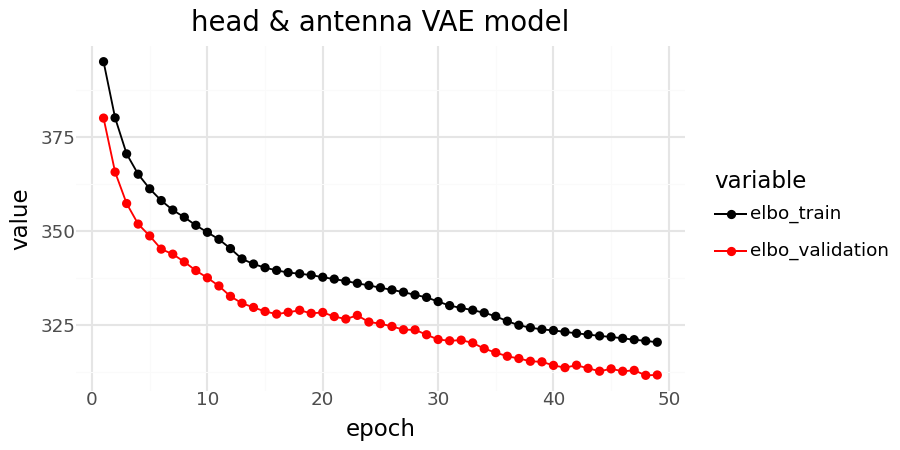

In [23]:
history_df = (
    broad_annotation_vae.history['elbo_train'].astype(float)
    .join(broad_annotation_vae.history['elbo_validation'].astype(float))
    .reset_index()
    .melt(id_vars = ['epoch'])
)

p.options.figure_size = 6, 3

p_ = (
    p.ggplot(p.aes(x = 'epoch', y = 'value', color = 'variable'), history_df.query('epoch > 0'))
    + p.geom_line()
    + p.geom_point()
    + p.scale_color_manual({'elbo_train': 'black', 'elbo_validation': 'red'})
    + p.ggtitle("head & antenna VAE model")
    + p.theme_minimal()
)


print(p_)

In [24]:
full_annotation_vae = sca.models.SCANVI.from_scvi_model(vae,adata=combined, unlabeled_category="Unlabeled",labels_key="annotation")
full_annotation_vae.train(max_epochs=50, check_val_every_n_epoch = 1)

INFO     Training for 50 epochs.                                                                                   


/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:183: UserWarning: Category 16 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/data/fields/_scanvi.py:56: UserWarning: Category 16 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: Fal

Epoch 1/50:   0%|          | 0/50 [00:00<?, ?it/s]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 2/50:   2%|▏         | 1/50 [00:23<18:56, 23.19s/it, v_num=1, train_loss_step=327, train_loss_epoch=356]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 3/50:   4%|▍         | 2/50 [00:46<18:34, 23.21s/it, v_num=1, train_loss_step=328, train_loss_epoch=328]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 4/50:   6%|▌         | 3/50 [01:09<18:11, 23.22s/it, v_num=1, train_loss_step=313, train_loss_epoch=322]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 5/50:   8%|▊         | 4/50 [01:32<17:47, 23.21s/it, v_num=1, train_loss_step=325, train_loss_epoch=318]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 6/50:  10%|█         | 5/50 [01:55<17:23, 23.19s/it, v_num=1, train_loss_step=303, train_loss_epoch=315]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 7/50:  12%|█▏        | 6/50 [02:19<17:00, 23.18s/it, v_num=1, train_loss_step=299, train_loss_epoch=312]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 8/50:  14%|█▍        | 7/50 [02:42<16:37, 23.19s/it, v_num=1, train_loss_step=309, train_loss_epoch=311]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 9/50:  16%|█▌        | 8/50 [03:05<16:14, 23.19s/it, v_num=1, train_loss_step=297, train_loss_epoch=309]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 10/50:  18%|█▊        | 9/50 [03:28<15:50, 23.18s/it, v_num=1, train_loss_step=297, train_loss_epoch=308]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 11/50:  20%|██        | 10/50 [03:52<15:30, 23.27s/it, v_num=1, train_loss_step=314, train_loss_epoch=306]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 12/50:  22%|██▏       | 11/50 [04:15<15:07, 23.26s/it, v_num=1, train_loss_step=337, train_loss_epoch=305]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 13/50:  24%|██▍       | 12/50 [04:38<14:43, 23.26s/it, v_num=1, train_loss_step=314, train_loss_epoch=304]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 14/50:  26%|██▌       | 13/50 [05:01<14:20, 23.25s/it, v_num=1, train_loss_step=318, train_loss_epoch=303]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 15/50:  28%|██▊       | 14/50 [05:25<13:59, 23.31s/it, v_num=1, train_loss_step=294, train_loss_epoch=302]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 16/50:  30%|███       | 15/50 [05:48<13:36, 23.32s/it, v_num=1, train_loss_step=297, train_loss_epoch=301]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 17/50:  32%|███▏      | 16/50 [06:11<13:12, 23.31s/it, v_num=1, train_loss_step=298, train_loss_epoch=299]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 18/50:  34%|███▍      | 17/50 [06:35<12:48, 23.30s/it, v_num=1, train_loss_step=297, train_loss_epoch=298]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 19/50:  36%|███▌      | 18/50 [06:58<12:25, 23.28s/it, v_num=1, train_loss_step=292, train_loss_epoch=298]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 20/50:  38%|███▊      | 19/50 [07:21<12:01, 23.28s/it, v_num=1, train_loss_step=299, train_loss_epoch=297]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 21/50:  40%|████      | 20/50 [07:45<11:38, 23.27s/it, v_num=1, train_loss_step=316, train_loss_epoch=296]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 22/50:  42%|████▏     | 21/50 [08:08<11:14, 23.27s/it, v_num=1, train_loss_step=271, train_loss_epoch=296]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 23/50:  44%|████▍     | 22/50 [08:31<10:51, 23.28s/it, v_num=1, train_loss_step=281, train_loss_epoch=295]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 24/50:  46%|████▌     | 23/50 [08:54<10:28, 23.30s/it, v_num=1, train_loss_step=282, train_loss_epoch=294]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 25/50:  48%|████▊     | 24/50 [09:18<10:05, 23.30s/it, v_num=1, train_loss_step=295, train_loss_epoch=294]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 26/50:  50%|█████     | 25/50 [09:41<09:42, 23.30s/it, v_num=1, train_loss_step=295, train_loss_epoch=293]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 27/50:  52%|█████▏    | 26/50 [10:04<09:19, 23.30s/it, v_num=1, train_loss_step=298, train_loss_epoch=293]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 28/50:  54%|█████▍    | 27/50 [10:28<08:55, 23.30s/it, v_num=1, train_loss_step=293, train_loss_epoch=292]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 29/50:  56%|█████▌    | 28/50 [10:51<08:32, 23.29s/it, v_num=1, train_loss_step=289, train_loss_epoch=292]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 30/50:  58%|█████▊    | 29/50 [11:14<08:08, 23.27s/it, v_num=1, train_loss_step=288, train_loss_epoch=292]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 31/50:  60%|██████    | 30/50 [11:37<07:46, 23.30s/it, v_num=1, train_loss_step=298, train_loss_epoch=291]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 32/50:  62%|██████▏   | 31/50 [12:01<07:22, 23.28s/it, v_num=1, train_loss_step=289, train_loss_epoch=291]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 33/50:  64%|██████▍   | 32/50 [12:24<06:58, 23.24s/it, v_num=1, train_loss_step=289, train_loss_epoch=290]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 34/50:  66%|██████▌   | 33/50 [12:47<06:35, 23.25s/it, v_num=1, train_loss_step=275, train_loss_epoch=290]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 35/50:  68%|██████▊   | 34/50 [13:10<06:12, 23.25s/it, v_num=1, train_loss_step=323, train_loss_epoch=290]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 36/50:  70%|███████   | 35/50 [13:34<05:48, 23.26s/it, v_num=1, train_loss_step=295, train_loss_epoch=290]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 37/50:  72%|███████▏  | 36/50 [13:57<05:25, 23.28s/it, v_num=1, train_loss_step=285, train_loss_epoch=290]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 38/50:  74%|███████▍  | 37/50 [14:20<05:02, 23.24s/it, v_num=1, train_loss_step=279, train_loss_epoch=289]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 39/50:  76%|███████▌  | 38/50 [14:43<04:38, 23.23s/it, v_num=1, train_loss_step=268, train_loss_epoch=289]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 40/50:  78%|███████▊  | 39/50 [15:07<04:15, 23.25s/it, v_num=1, train_loss_step=305, train_loss_epoch=288]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 41/50:  80%|████████  | 40/50 [15:30<03:52, 23.27s/it, v_num=1, train_loss_step=285, train_loss_epoch=288]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 42/50:  82%|████████▏ | 41/50 [15:53<03:29, 23.28s/it, v_num=1, train_loss_step=304, train_loss_epoch=288]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 43/50:  84%|████████▍ | 42/50 [16:17<03:06, 23.31s/it, v_num=1, train_loss_step=295, train_loss_epoch=288]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 44/50:  86%|████████▌ | 43/50 [16:40<02:43, 23.33s/it, v_num=1, train_loss_step=278, train_loss_epoch=288]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 45/50:  88%|████████▊ | 44/50 [17:03<02:19, 23.32s/it, v_num=1, train_loss_step=296, train_loss_epoch=288]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 46/50:  90%|█████████ | 45/50 [17:27<01:56, 23.34s/it, v_num=1, train_loss_step=288, train_loss_epoch=287]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 47/50:  92%|█████████▏| 46/50 [17:50<01:33, 23.36s/it, v_num=1, train_loss_step=302, train_loss_epoch=287]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 48/50:  94%|█████████▍| 47/50 [18:14<01:10, 23.36s/it, v_num=1, train_loss_step=282, train_loss_epoch=287]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 49/50:  96%|█████████▌| 48/50 [18:37<00:46, 23.35s/it, v_num=1, train_loss_step=271, train_loss_epoch=287]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 50/50:  98%|█████████▊| 49/50 [19:00<00:23, 23.33s/it, v_num=1, train_loss_step=284, train_loss_epoch=287]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 50/50: 100%|██████████| 50/50 [19:23<00:00, 23.33s/it, v_num=1, train_loss_step=253, train_loss_epoch=287]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 50/50: 100%|██████████| 50/50 [19:23<00:00, 23.28s/it, v_num=1, train_loss_step=253, train_loss_epoch=287]


/scratch/6735487.1.iris-gpu-pub/ipykernel_116641/3305563390.py:20: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


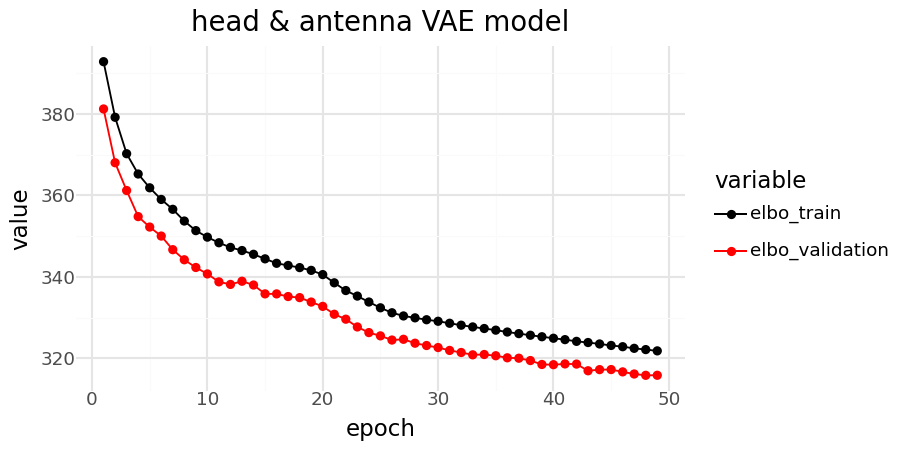

In [25]:
history_df = (
    full_annotation_vae.history['elbo_train'].astype(float)
    .join(full_annotation_vae.history['elbo_validation'].astype(float))
    .reset_index()
    .melt(id_vars = ['epoch'])
)

p.options.figure_size = 6, 3

p_ = (
    p.ggplot(p.aes(x = 'epoch', y = 'value', color = 'variable'), history_df.query('epoch > 0'))
    + p.geom_line()
    + p.geom_point()
    + p.scale_color_manual({'elbo_train': 'black', 'elbo_validation': 'red'})
    + p.ggtitle("head & antenna VAE model")
    + p.theme_minimal()
)


print(p_)

In [26]:
broad_model = "/projectnb/mccall/sbandyadka/drpr42d_snrnaseq/analysis/scarches/broad_model_head_antenna/"
broad_annotation_vae.save(broad_model, overwrite=True)
full_model = "/projectnb/mccall/sbandyadka/drpr42d_snrnaseq/analysis/scarches/full_model_head_antenna/"
full_annotation_vae.save(full_model, overwrite=True)

In [27]:
combined.obs['broad_annotation_predicted'] = broad_annotation_vae.predict(combined)
combined.obs['full_annotation_predicted'] = full_annotation_vae.predict(combined)
combined.obs

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:183: UserWarning: Category 16 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/data/fields/_scanvi.py:56: UserWarning: Category 16 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.


age batch  batch_id  \
AAACCCAAGTTGGGAC-6e294c34__FCA55_Male_antenna_a...   5     0       4.0   
AAACCCACACGTCGGT-6e294c34__FCA55_Male_antenna_a...   5     0       4.0   
AAACCCAGTAGTAAGT-6e294c34__FCA55_Male_antenna_a...   5     0       4.0   
AAACCCAGTGACTATC-6e294c34__FCA55_Male_antenna_a...   5     0       4.0   
AAACCCAGTGCGACAA-6e294c34__FCA55_Male_antenna_a...   5     0       4.0   
...                                                 ..   ...       ...   
TTTGTTGGTAACTTCG-1                                  42     0       NaN   
TTTGTTGGTCATCAGT-1                                  42     0       NaN   
TTTGTTGGTGAGCTCC-1                                  42     0       NaN   
TTTGTTGGTTCCGTTC-1                                  42     0       NaN   
TTTGTTGTCGAGTTGT-1                                  42     0       NaN   

                                                    celda_decontx__clusters  \
AAACCCAAGTTGGGAC-6e294c34__FCA55_Male_antenna_a...                      1.0   
AAACCCACACGTCGGT-6e294c34__FCA55_Male_antenna_a...                      1.0   
AAACCCAGTAGTAAGT-6e294c34__FCA55_Male_antenna_a...                      2.0   
AAACCCAGTGACTATC-6e294c34__FCA55_Male_antenna_a...                      2.0   
AAACCCAGTGCGACAA-6e294c34__FCA55_Male_antenna_a...                      3.0   
...                                                                     ...   
TTTGTTGGTAACTTCG-1                                                      NaN   
TTTGTTGGTCATCAGT-1                                                      NaN   
TTTGTTGGTGAGCTCC-1                                                      NaN   
TTTGTTGGTTCCGTTC-1                                                      NaN   
TTTGTTGTCGAGTTGT-1                                                      NaN   

                                                    celda_decontx__contamination  \
AAACCCAAGTTGGGAC-6e294c34__FCA55_Male_antenna_a...                      0.159537   
AAACCCACACGTCGGT-6e294c34__FCA55_Male_antenna_a...                      0.021540   
AAACCCAGTAGTAAGT-6e294c34__FCA55_Male_antenna_a...                      0.269333   
AAACCCAGTGACTATC-6e294c34__FCA55_Male_antenna_a...                      0.557898   
AAACCCAGTGCGACAA-6e294c34__FCA55_Male_antenna_a...                      0.166683   
...                                                                          ...   
TTTGTTGGTAACTTCG-1                                                           NaN   
TTTGTTGGTCATCAGT-1                                                           NaN   
TTTGTTGGTGAGCTCC-1                                                           NaN   
TTTGTTGGTTCCGTTC-1                                                           NaN   
TTTGTTGTCGAGTTGT-1                                                           NaN   

                                                    celda_decontx__doublemad_predicted_outliers  \
AAACCCAAGTTGGGAC-6e294c34__FCA55_Male_antenna_a...                                        False   
AAACCCACACGTCGGT-6e294c34__FCA55_Male_antenna_a...                                        False   
AAACCCAGTAGTAAGT-6e294c34__FCA55_Male_antenna_a...                                        False   
AAACCCAGTGACTATC-6e294c34__FCA55_Male_antenna_a...                                        False   
AAACCCAGTGCGACAA-6e294c34__FCA55_Male_antenna_a...                                        False   
...                                                                                         ...   
TTTGTTGGTAACTTCG-1                                                                         <NA>   
TTTGTTGGTCATCAGT-1                                                                         <NA>   
TTTGTTGGTGAGCTCC-1                                                                         <NA>   
TTTGTTGGTTCCGTTC-1                                                                         <NA>   
TTTGTTGTCGAGTTGT-1                                                                         <NA>   

               

In [28]:
broad_annotation_mappings = dict(zip(combined.obs.index, combined.obs.broad_annotation_predicted))
full_annotation_mappings = dict(zip(combined.obs.index, combined.obs.full_annotation_predicted))

In [29]:
query.obs['broad_annotation'] = query.obs.index.map(broad_annotation_mappings)
query.obs['full_annotation'] = query.obs.index.map(full_annotation_mappings)

In [30]:
print(query.X.max(),query.X.min())

1089.0 0.0


In [31]:
query_labeled = query.copy()

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


In [32]:
query_labeled.layers['raw_counts'] = query_labeled.X
sc.pp.normalize_total(query_labeled)
sc.pp.log1p(query_labeled)
sc.pp.highly_variable_genes(query_labeled,
                            batch_key="tissue_batch",
                            n_top_genes=2000,
                            subset=False)

normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [33]:
query_labeled.raw = query_labeled
sc.tl.pca(query_labeled, n_comps=200)


computing PCA
    with n_comps=200
    finished (0:00:02)


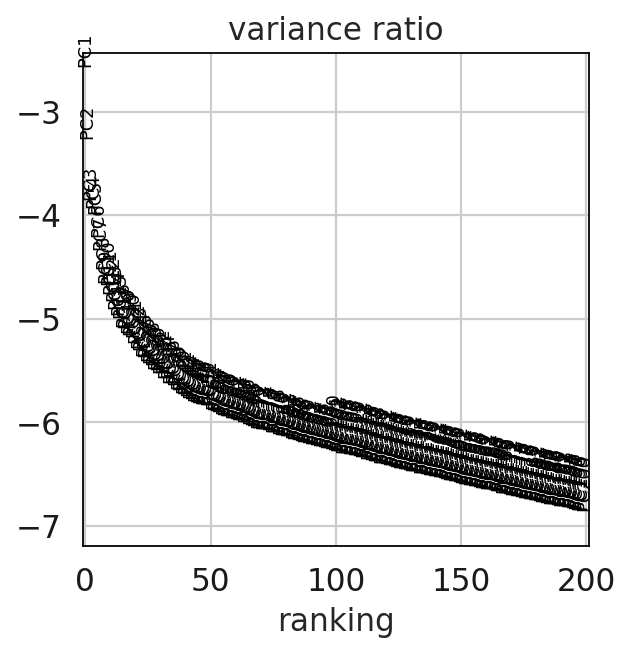

In [34]:
sc.pl.pca_variance_ratio(query_labeled, n_pcs=200, log=True)

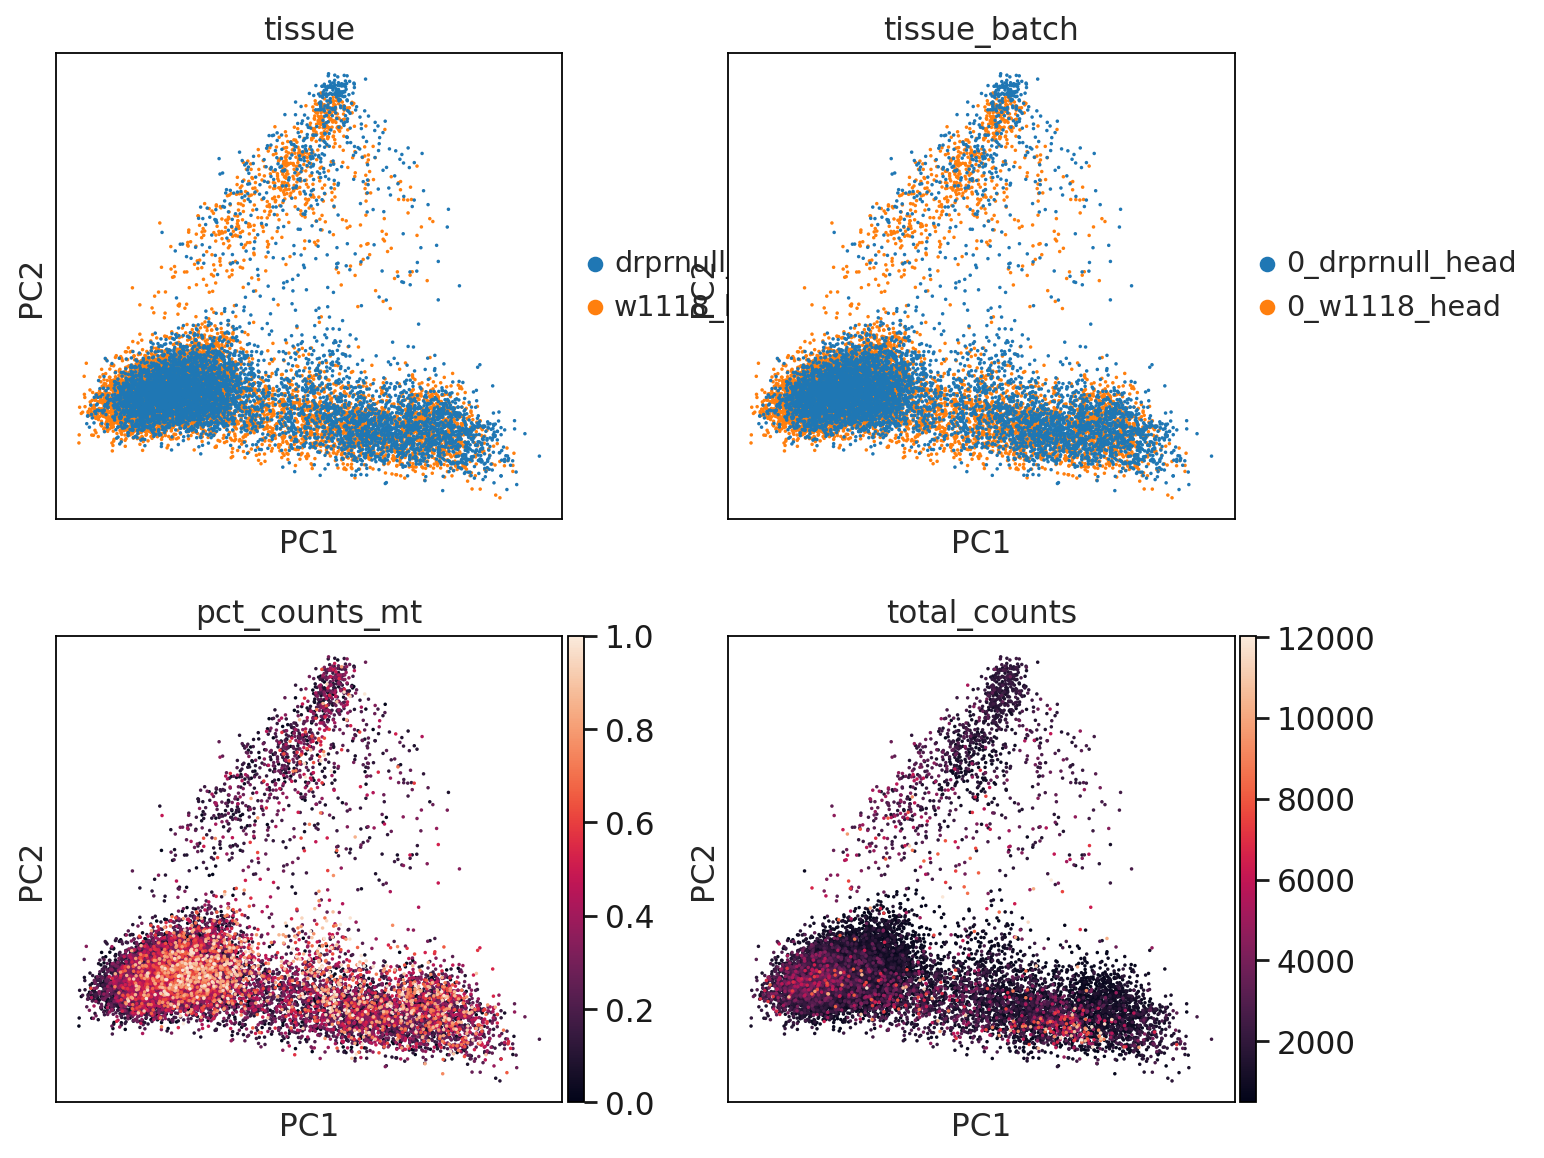

In [35]:
sc.pl.pca(
    query_labeled,
    color=["tissue", "tissue_batch", "pct_counts_mt", "total_counts"],
    ncols=2,
    size=10
)

In [36]:
sc.pp.neighbors(query_labeled)
sc.tl.umap(query_labeled)

computing neighbors
    using 'X_pca' with n_pcs = 200
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:17)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:12)


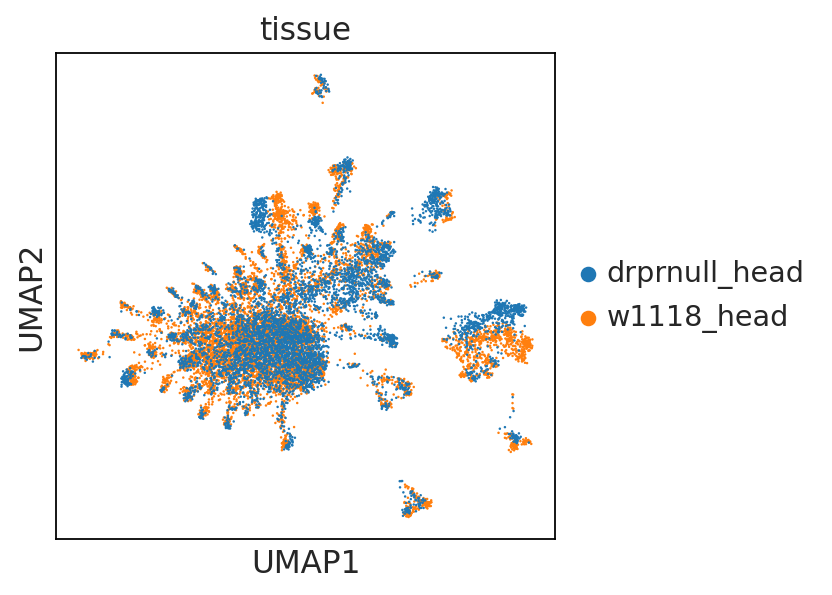

In [37]:
sc.pl.umap(
    query_labeled,
    color="tissue",
    # Setting a smaller point size to get prevent overlap
    size=5,
)

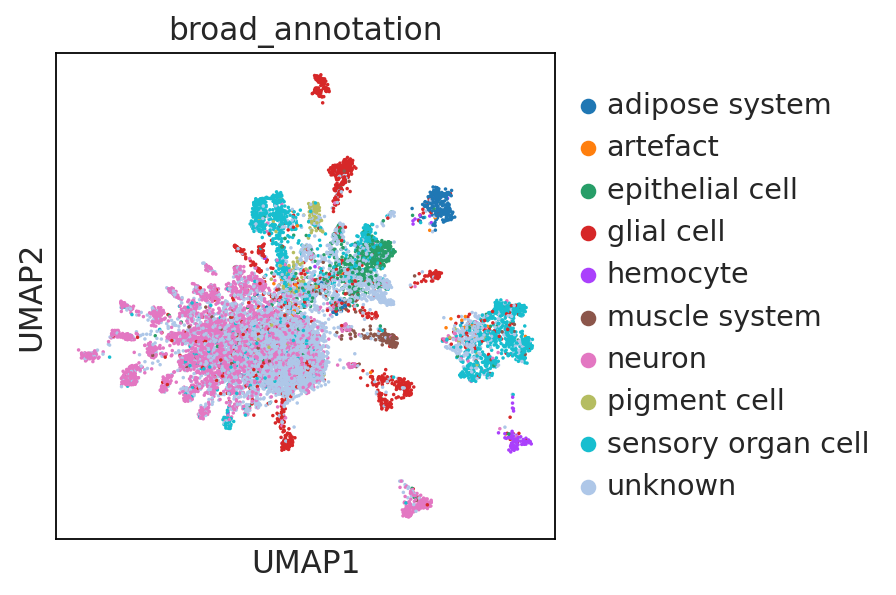

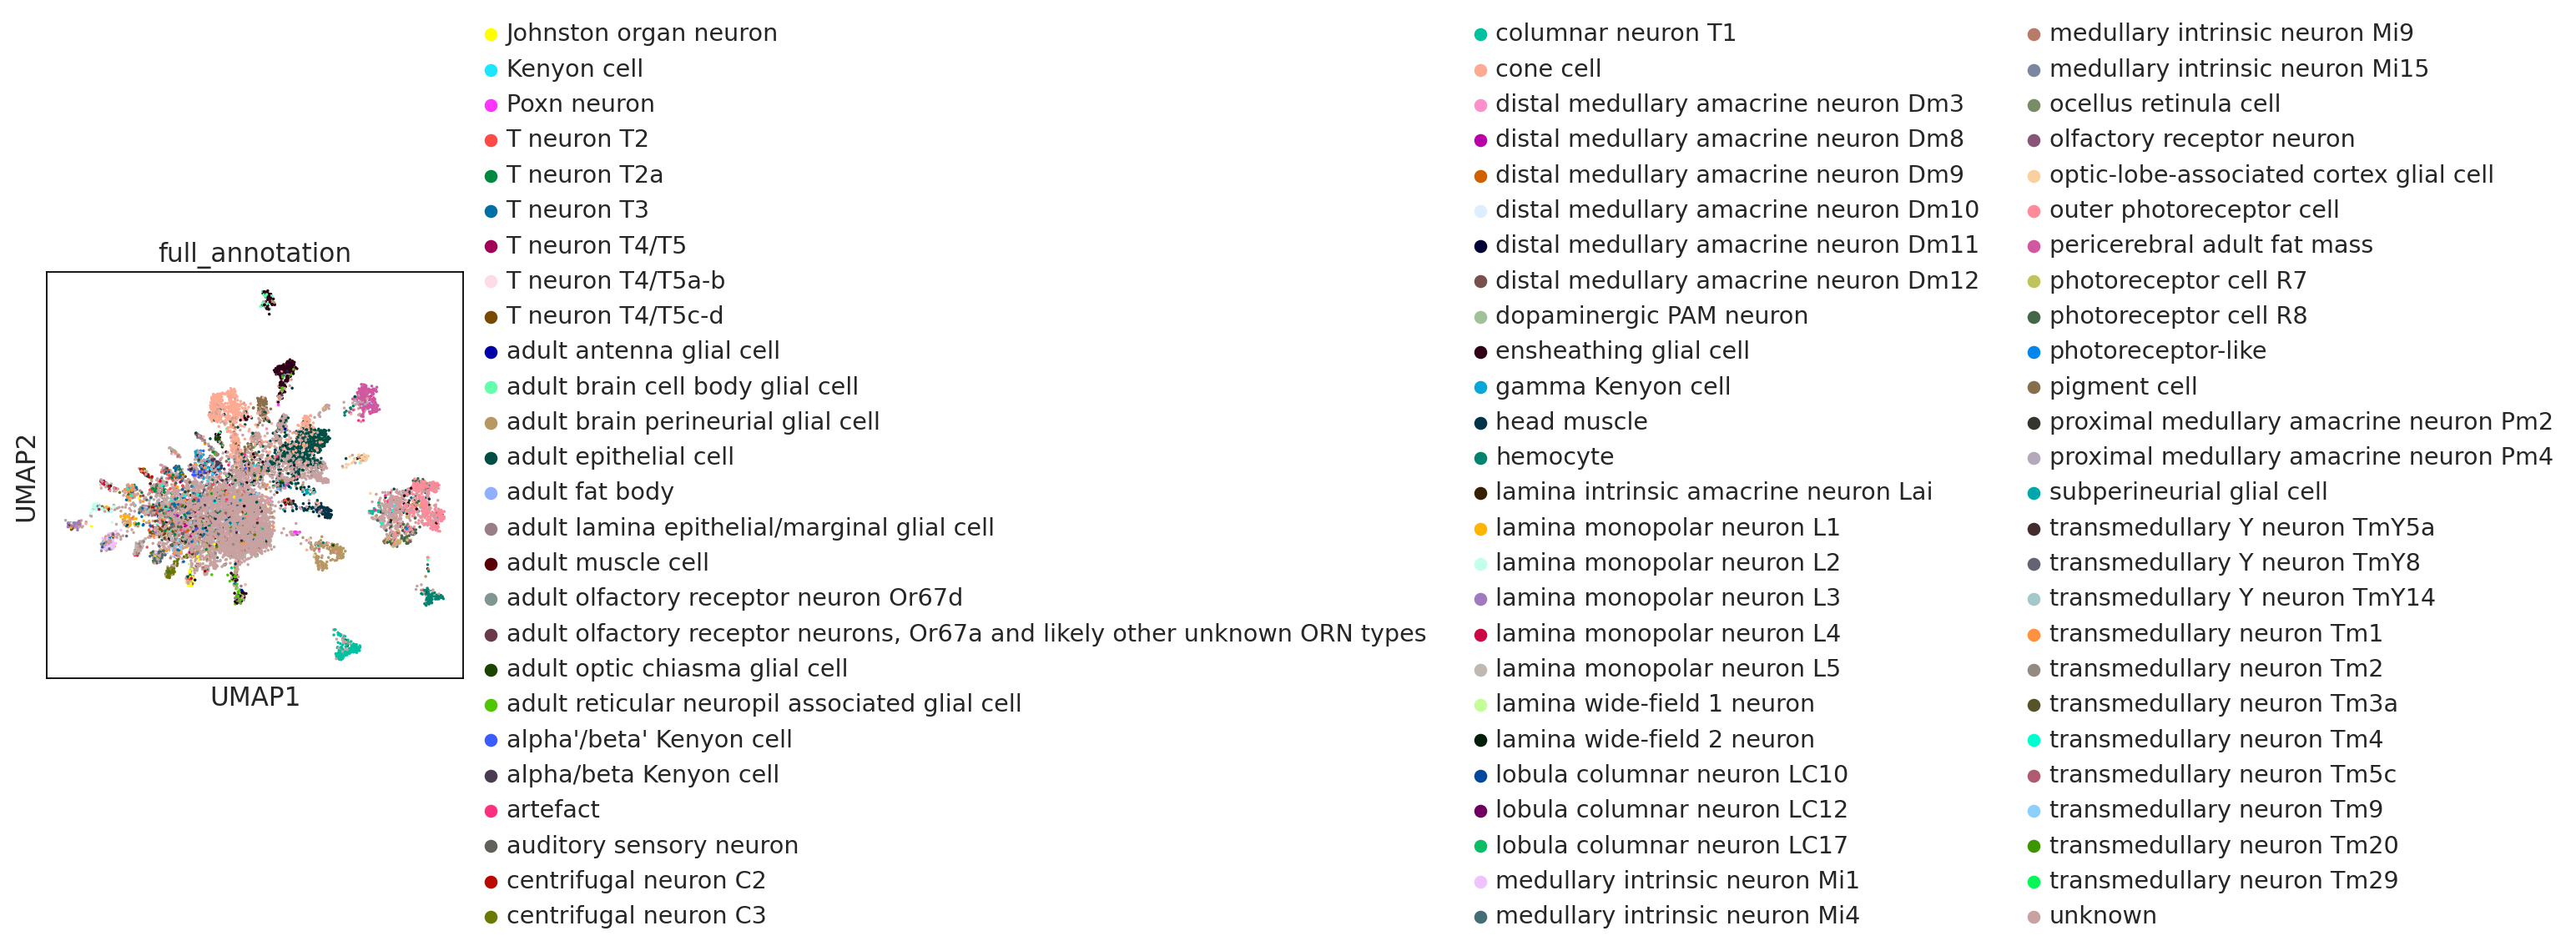

In [38]:
sc.pl.umap(
    query_labeled,
    color=["broad_annotation"],
    size=10,ncols=1
)

sc.pl.umap(
    query_labeled,
    color=["full_annotation"],
    size=10,ncols=1
)

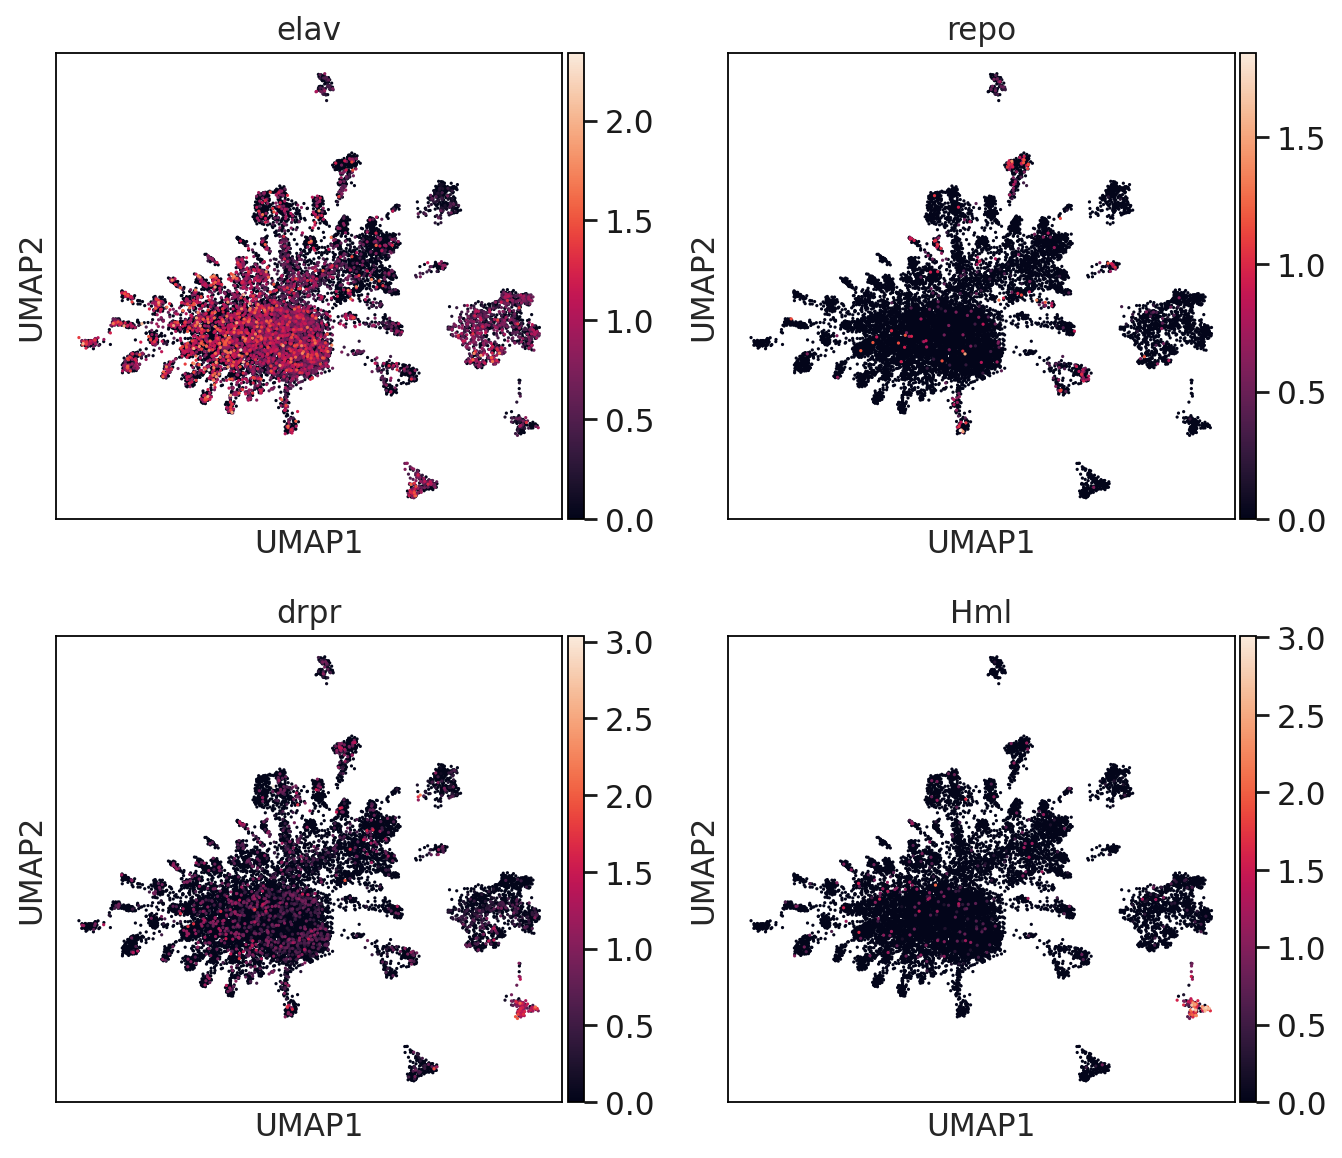

In [39]:
sc.pl.umap(
    query_labeled,
    color=["elav", "repo", "drpr","Hml"], ncols=2
)

In [40]:
markers = {"neurons": ["elav","lncRNA:noe","VAChT","VGlut","Gad1","Vmat","SerT","Tdc2","ple"], # neurons
           "glia": ["repo","lncRNA:CR34335","alrm","wrapper","Indy","moody"],#glia 
           "photoreceptors": ["ninaC",	"trp",	"trpl"], #photoreceptors
           "hemocytes": ["Hml"], #hemocytes
           "fatbody": ["ppl"],#fatbody
           "drpr":["drpr"]}

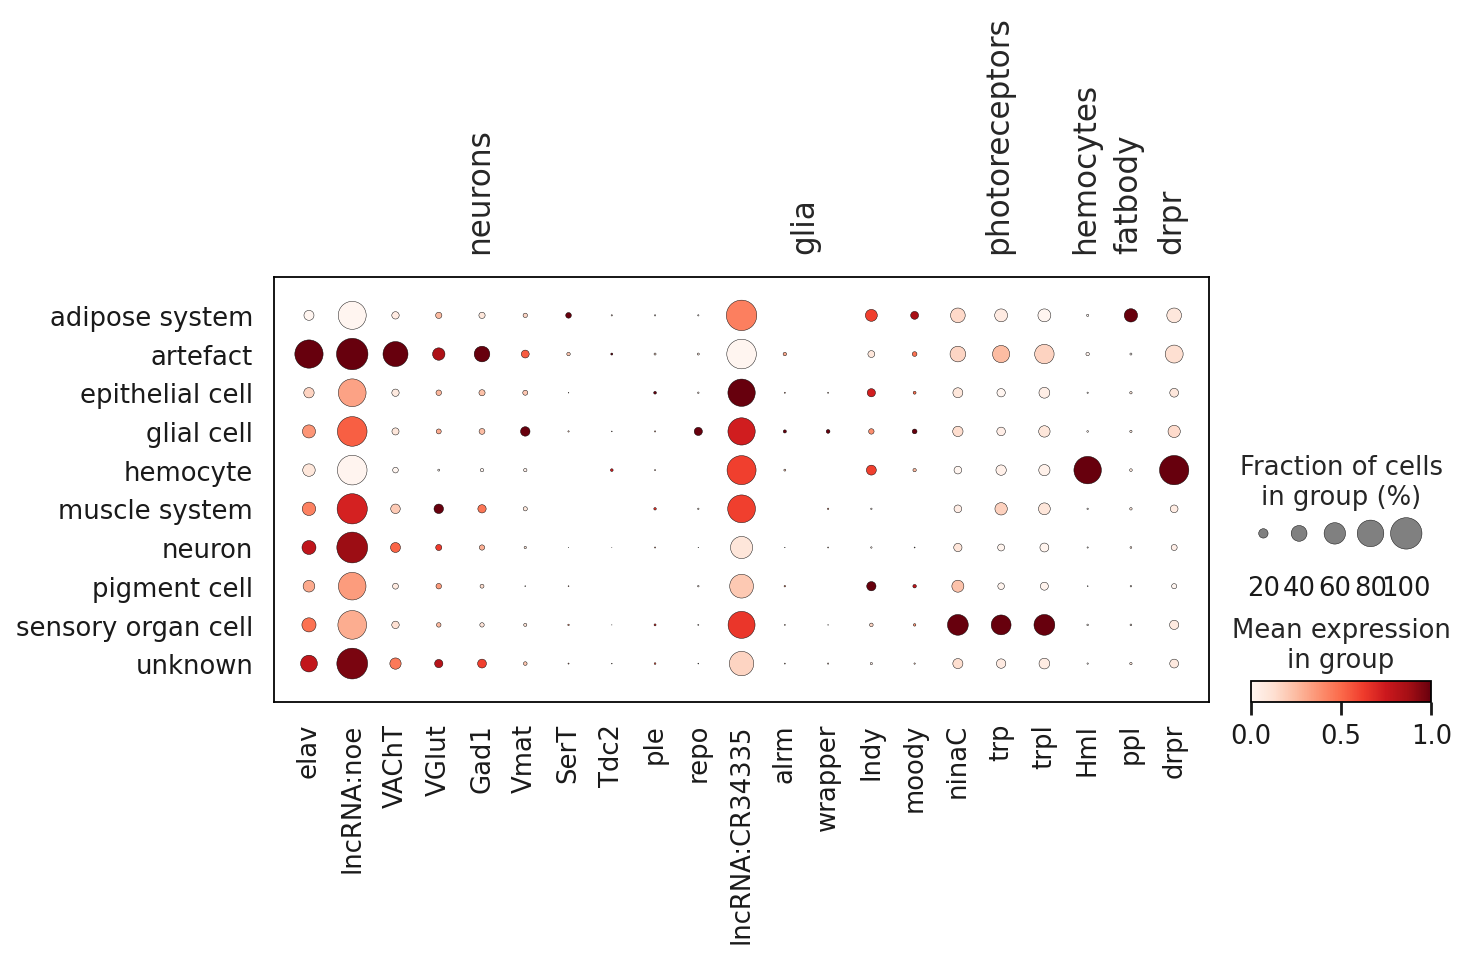

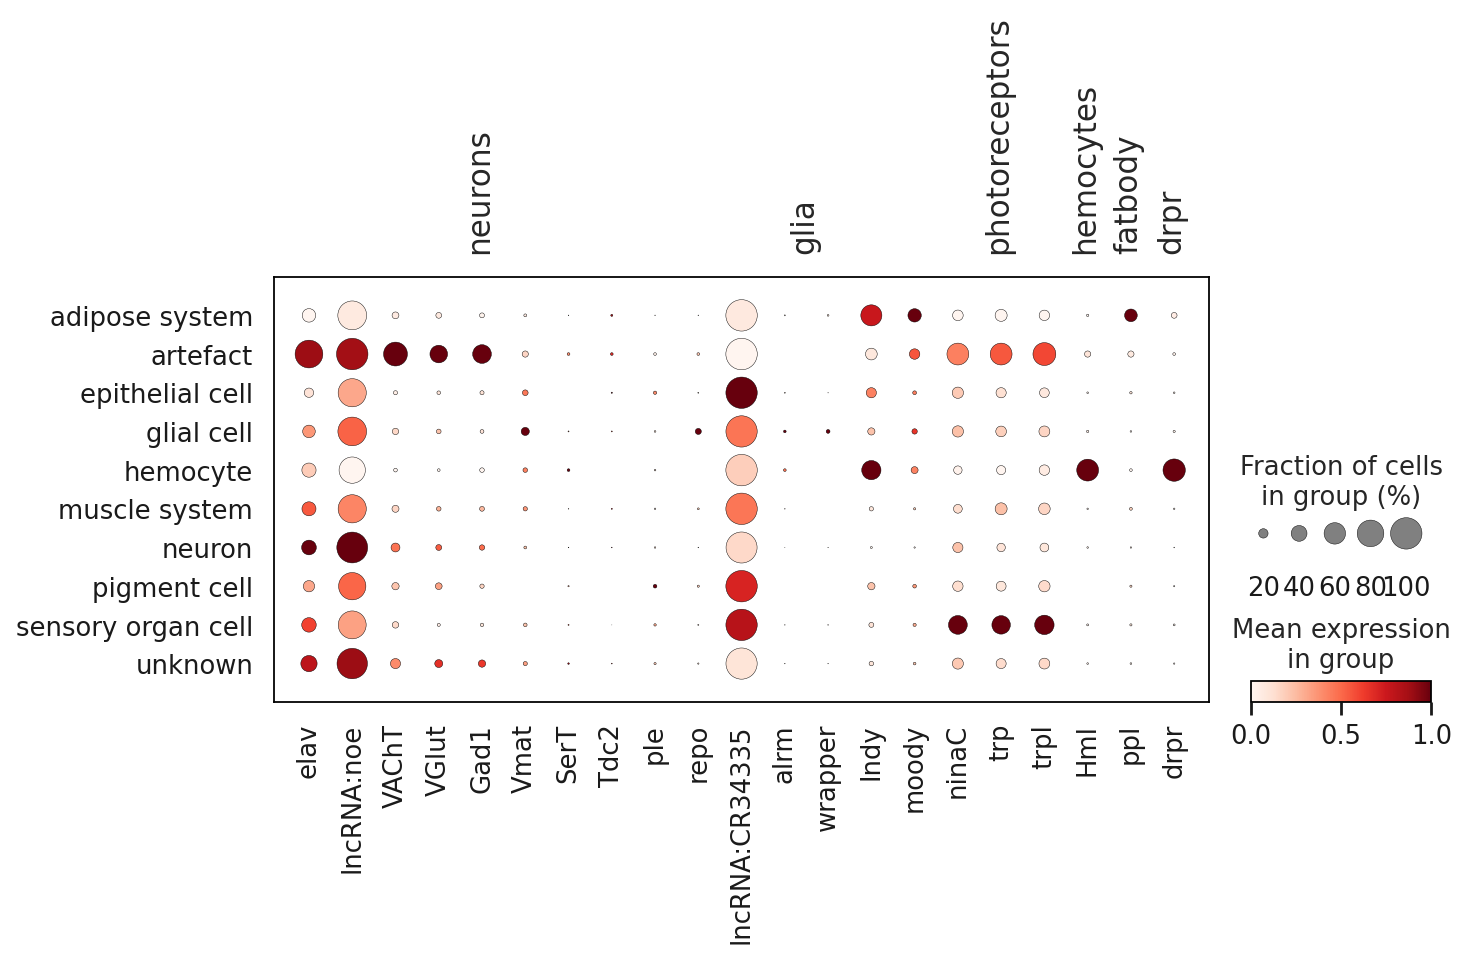

In [41]:

sc.pl.dotplot(query_labeled[query_labeled.obs['tissue']=="w1118_head"], markers, groupby="broad_annotation", standard_scale="var")
sc.pl.dotplot(query_labeled[query_labeled.obs['tissue']=="drprnull_head"], markers, groupby="broad_annotation", standard_scale="var")

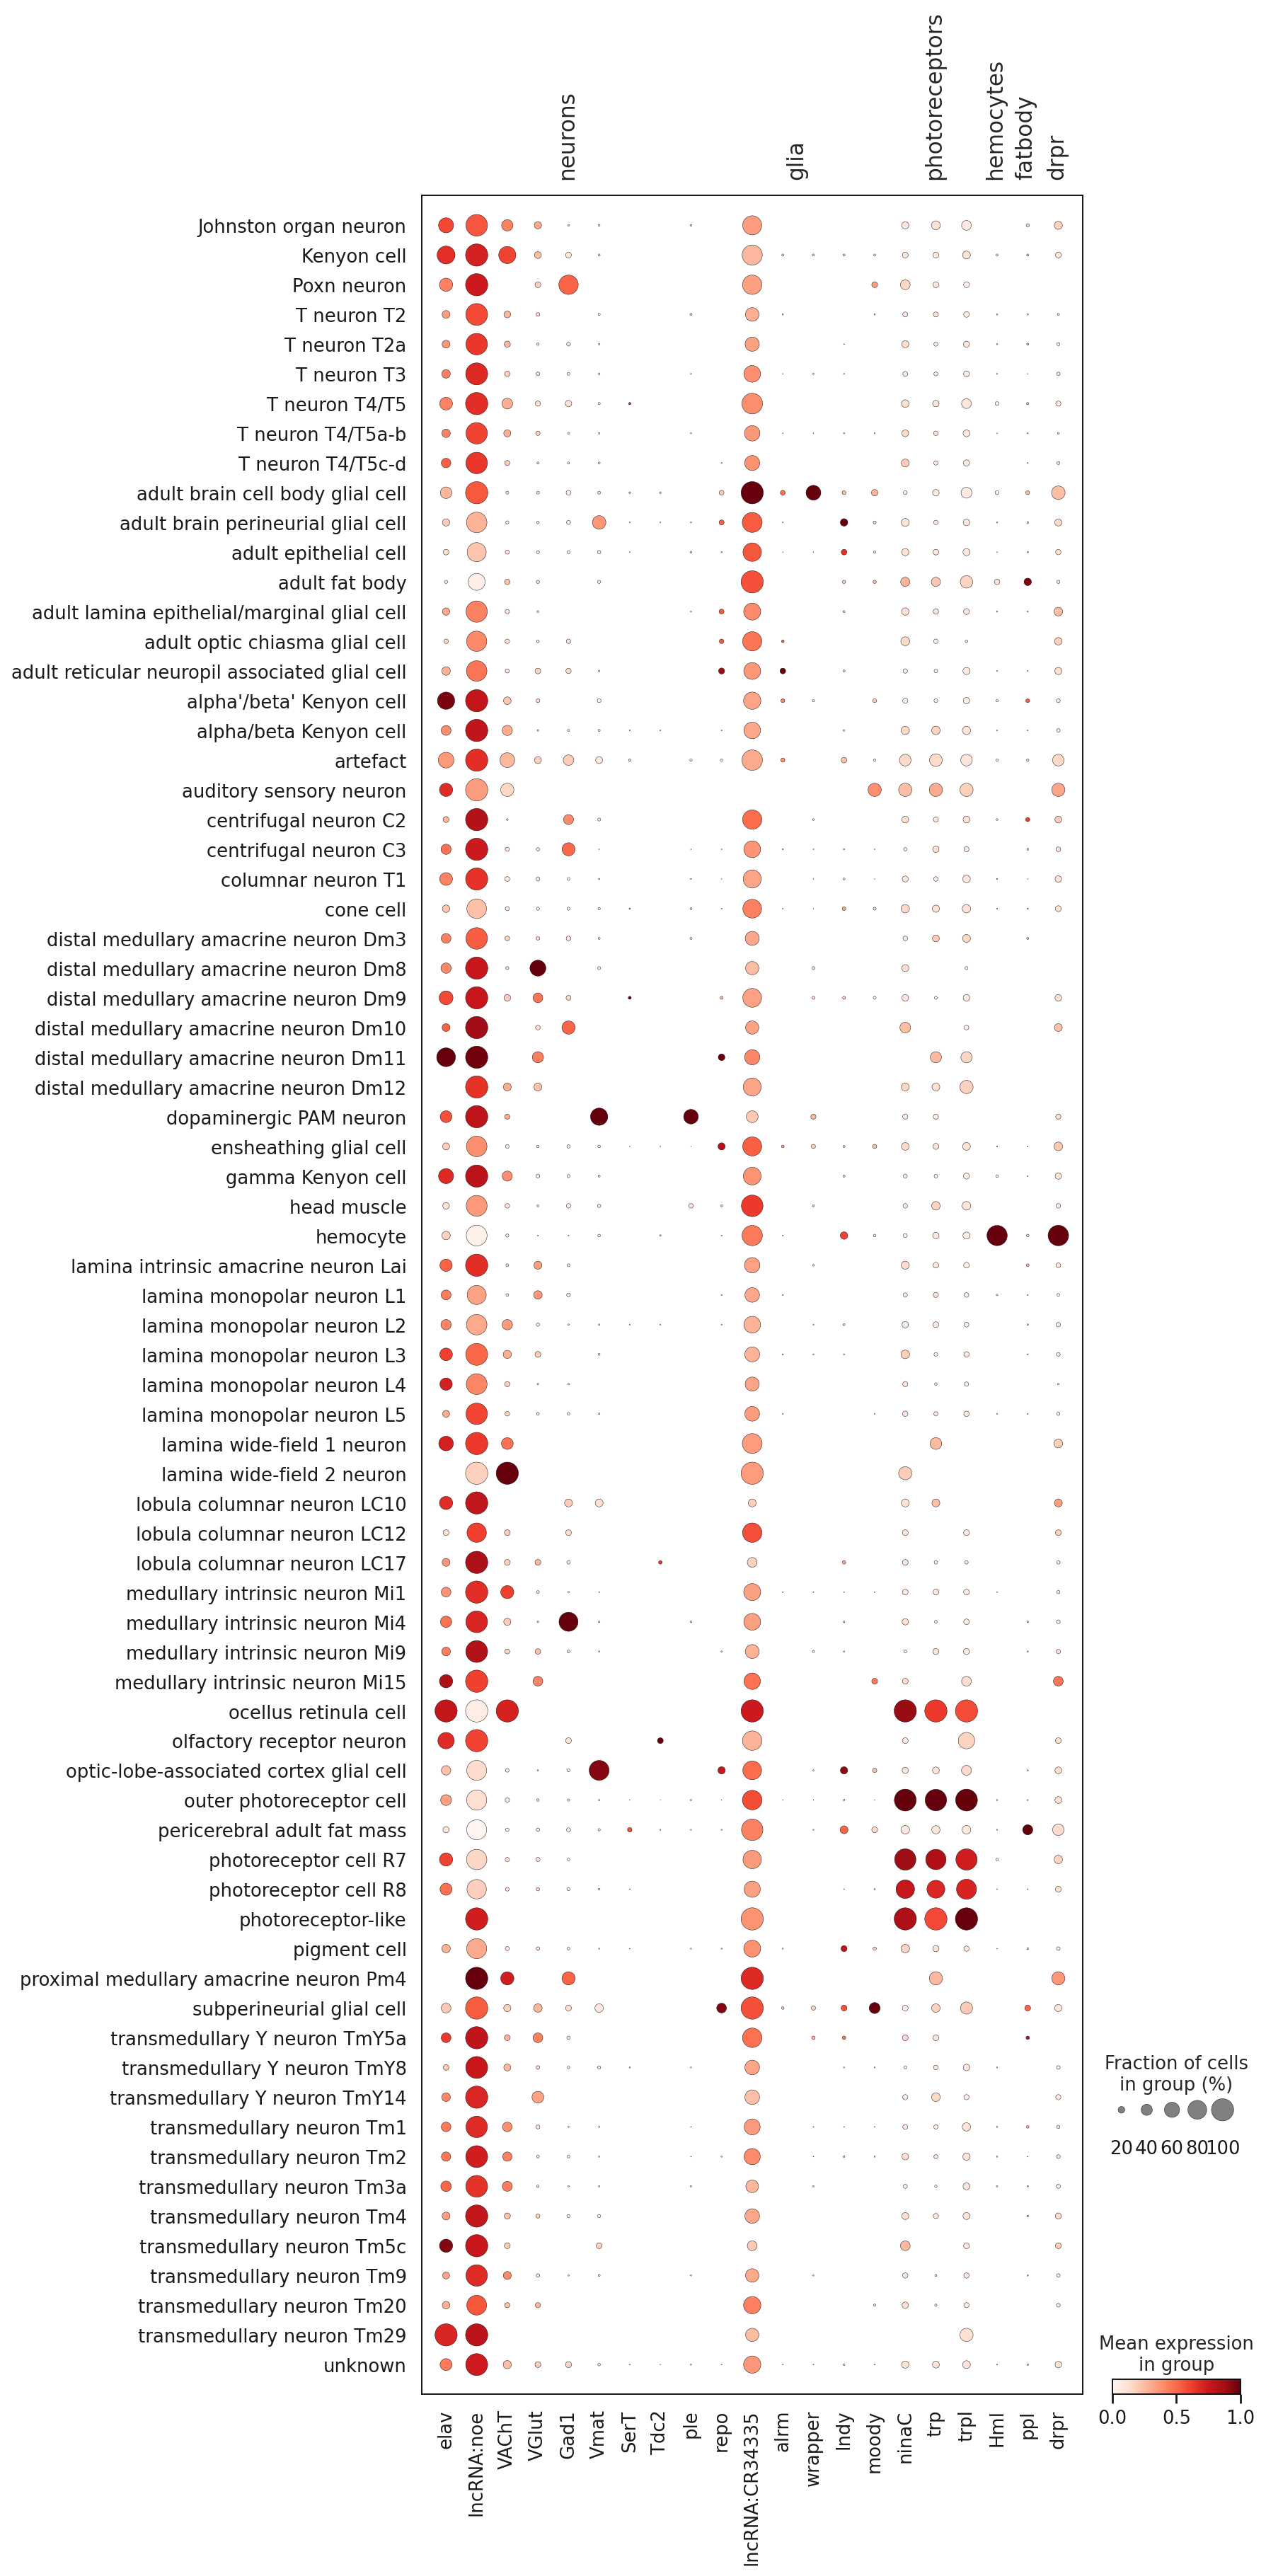

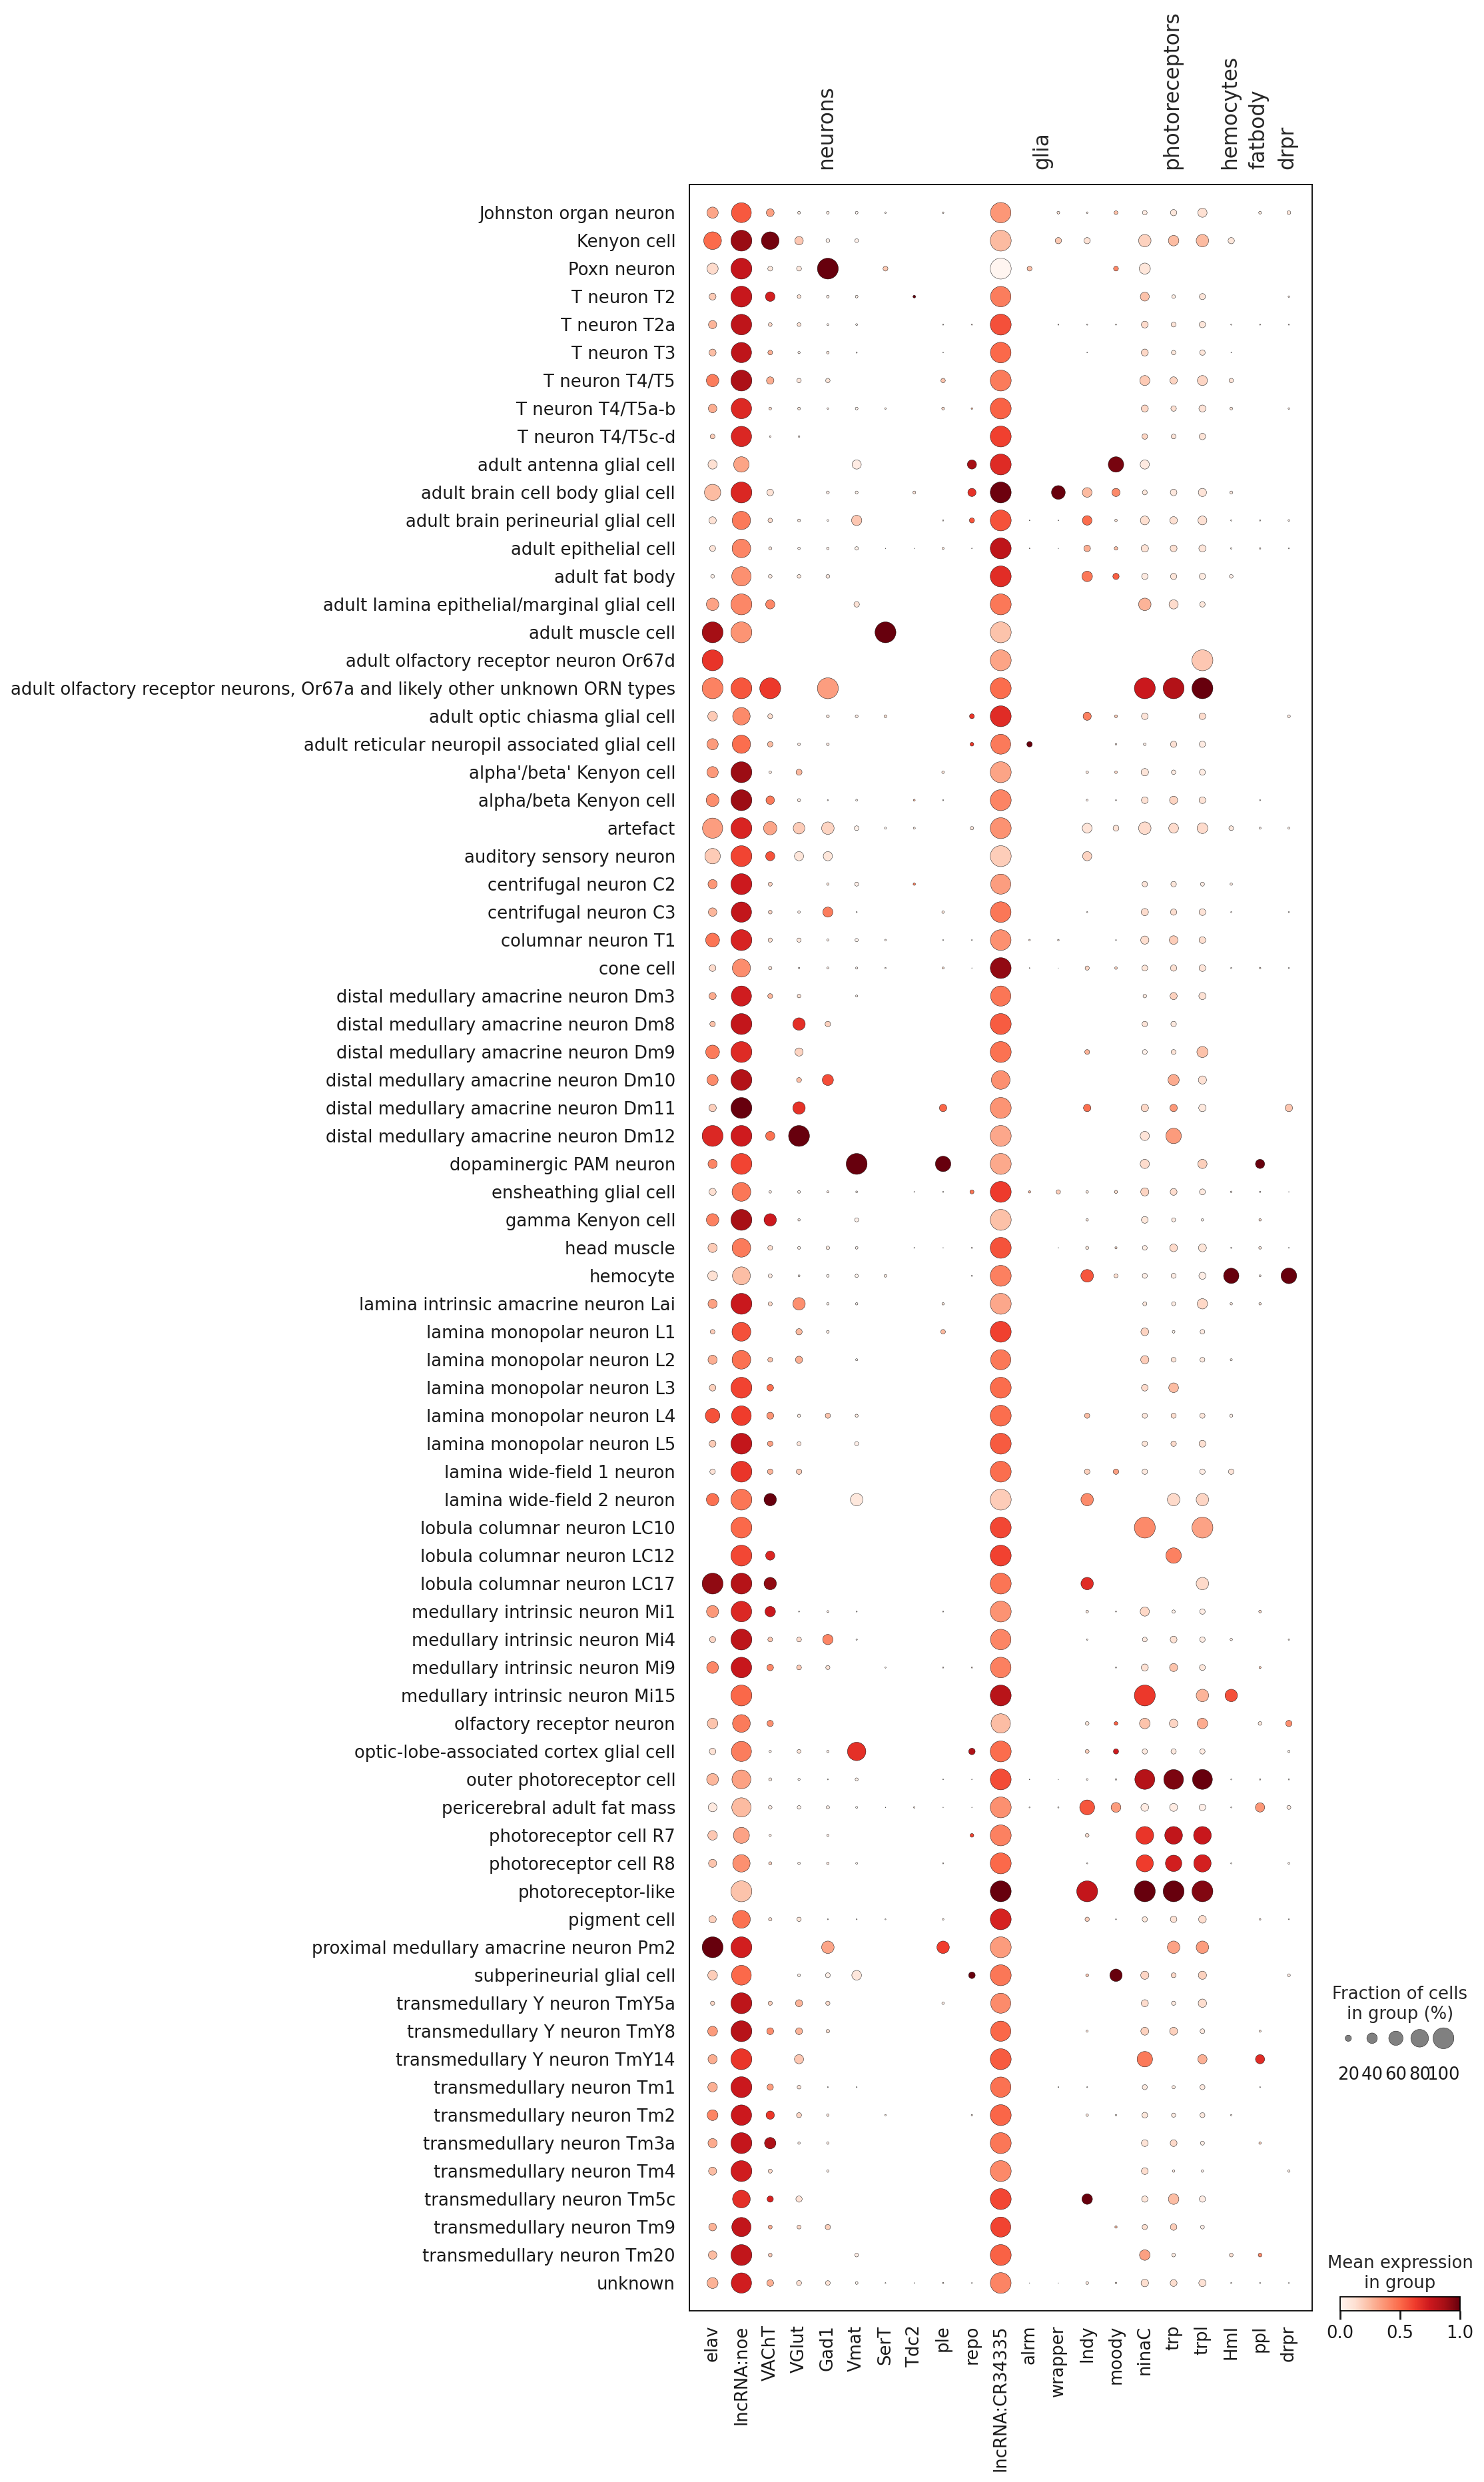

In [42]:
sc.pl.dotplot(query_labeled[query_labeled.obs['tissue']=="w1118_head"], markers, groupby="full_annotation", standard_scale="var")
sc.pl.dotplot(query_labeled[query_labeled.obs['tissue']=="drprnull_head"], markers, groupby="full_annotation", standard_scale="var")

In [ ]:
#combined.write(outputpath.joinpath("combined.h5"))
query.write(outputpath.joinpath("query_head_antenna.h5"))
query_labeled.write(outputpath.joinpath("query_labeled_head_antenna.h5"))